In [108]:
import os
import nltk
import re
import spacy
import pickle
import torch

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from enum import Enum
from tqdm import tqdm
from spacy.tokens import Token
from gensim.models import KeyedVectors

from sklearn import metrics
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, SGDRegressor, ElasticNet
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, VotingClassifier, ExtraTreesClassifier

from transformers import BertTokenizer, BertModel, RobertaModel, RobertaTokenizer


# Loading the data


In [31]:
TRAIN_PATH = os.path.join(os.getcwd(), "data", "train.csv")
TEST_PATH = os.path.join(os.getcwd(), "data", "test.csv")


Let's rename the columns to make them easier to work with.


In [32]:
data_df = pd.read_csv(TRAIN_PATH, index_col="index")
data_df = data_df.rename(
    columns={
        "tweet": "text",
        "prejudice_woman": "woman",
        "prejudice_lgbtiq": "lgbtiq",
        "prejudice_inmigrant_race": "race",
        "mean_prejudice": "mean",
    }
)

data_df = data_df.sort_index()

display(data_df.head(5))
display(data_df.describe())

,text,humor,woman,lgbtiq,race,gordofobia,mean
index,,,,,,,
9,MENTION Ya estará colocada en algún chiringuit...,0,1,0,0,0,3.4
22,"Sin querer, hoy le dije “Hola” a una feminista...",1,1,0,0,0,3.8
30,"En este capítulo, que se transmitió en el Cana...",0,0,1,0,0,2.2
40,MENTION MENTION MENTION Concuerdo contigo en e...,0,0,1,0,0,3.8
45,– ¡No es no! ¡En mi cuerpo mando yo!\n– ¡Así s...,1,1,0,0,0,2.2


,humor,woman,lgbtiq,race,gordofobia,mean
count,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000
mean,0.325346,0.483714,0.227256,0.248596,0.080120,3.053126
std,0.468592,0.499828,0.419138,0.432280,0.271529,0.809173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,2.400000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,3.600000
max,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


Let's load the spacy model


In [33]:
SPACY_MODEL = "es_core_news_lg"
# TODO: Try other spanish spacy models: es_core_news_md, es_core_news_lg, es_dep_news_trf

try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)


By using the default pipeline of the spacy model, we can get tokens with information about their part of speech, lemma, whether they are a stop word, etc.


In [34]:
# Tokenize text
parsed_df = data_df.copy()
parsed_df["tokens"] = list(nlp.pipe(parsed_df["text"]))
parsed_df["tokens"] = parsed_df["tokens"].apply(lambda x: [token for token in x])
display(parsed_df.head(5))


,text,humor,woman,lgbtiq,race,gordofobia,mean,tokens
index,,,,,,,,
9,MENTION Ya estará colocada en algún chiringuit...,0,1,0,0,0,3.4,"[MENTION, Ya, estará, colocada, en, algún, chi..."
22,"Sin querer, hoy le dije “Hola” a una feminista...",1,1,0,0,0,3.8,"[Sin, querer, ,, hoy, le, dije, “, Hola, ”, a,..."
30,"En este capítulo, que se transmitió en el Cana...",0,0,1,0,0,2.2,"[En, este, capítulo, ,, que, se, transmitió, e..."
40,MENTION MENTION MENTION Concuerdo contigo en e...,0,0,1,0,0,3.8,"[MENTION, MENTION, MENTION, Concuerdo, contigo..."
45,– ¡No es no! ¡En mi cuerpo mando yo!\n– ¡Así s...,1,1,0,0,0,2.2,"[–, ¡, No, es, no, !, ¡, En, mi, cuerpo, mando..."


In [35]:
# Show some data about a token
token: Token = parsed_df["tokens"].iloc[0][5]
print("Text: ", token.text)
print("Lemma: ", token.lemma_)
print("POS: ", token.pos_)
print("Tag: ", token.tag_)
print("Dep: ", token.dep_)
print("Shape: ", token.shape_)
print("Is alpha: ", token.is_alpha)
print("Is stop: ", token.is_stop)


Text:  algún
Lemma:  alguno
POS:  DET
Tag:  DET
Dep:  det
Shape:  xxxx
Is alpha:  True
Is stop:  True


## Token filtering utility

Let's create utility functions to filter the tokens based on their attributes. We can easily use these functions to filter the tokens, build and experiment with different representations of the data in the next steps of the project.


In [36]:
EMOJI_PATTERN = re.compile(
    "["
    + "\U0001F600-\U0001F64F"
    + "\U0001F300-\U0001F5FF"
    + "\U0001F680-\U0001F6FF"
    + "\U0001F1E0-\U0001F1FF"
    + "\U00002500-\U00002BEF"
    + "\U00002702-\U000027B0"
    + "\U00002702-\U000027B0"
    + "\U000024C2-\U0001F251"
    + "\U0001f926-\U0001f937"
    + "\U00010000-\U0010ffff"
    + "\u2640-\u2642"
    + "\u2600-\u2B55"
    + "\u200d"
    + "\u23cf"
    + "\u23e9"
    + "\u231a"
    + "\ufe0f"
    + "\u3030"
    + "]+",
    flags=re.UNICODE,
)

try:
    STOPWORDS = nltk.corpus.stopwords.words("spanish")
except LookupError:
    nltk.download("stopwords")
    STOPWORDS = nltk.corpus.stopwords.words("spanish")

In [37]:
FILTER_FUNC = {
    "punct": lambda token: token.is_punct,
    "stopwords": lambda token: token.text.lower() in STOPWORDS,
    "emoji": lambda token: EMOJI_PATTERN.match(token.text),
    "number": lambda token: token.like_num,
    "newline": lambda token: re.match(r"\n+", token.text),
    "space": lambda token: token.is_space and not re.match(r"\n+", token.text),
    "tags": lambda token: token.text in ["MENTION", "HASHTAG", "URL"],
}


class Filter(Enum):
    PUNCT = "punct"
    STOPWORDS = "stopwords"
    EMOJI = "emoji"
    NUMBER = "number"
    NEWLINE = "newline"
    SPACE = "space"
    TAGS = "tags"


def filter_tokens(series: pd.Series, filters: list[Filter]) -> pd.Series:
    """
    Filters a series of tokens using the given filters.
    args:
        series: a series of lists of tokens
        filters: a list of filters to apply
    returns:
        a series of lists of tokens
    """
    return series.apply(
        lambda tokens: [
            token
            for token in tokens
            if not any([FILTER_FUNC[filter.value](token) for filter in filters])
        ]
    )

In [38]:
def test_filter_tokens(result, expected):
    error = False
    for token, expected_token in zip(result, expected):
        try:
            assert token.text == expected_token
        except AssertionError:
            print(f"Expected: '{expected_token}', got: '{token.text}'")
            error = True

    if not error:
        print("Test passed!")


# test Filter.PUNCT
result = filter_tokens(parsed_df["tokens"], [Filter.PUNCT]).loc[22]
expected = [
    "Sin",
    "querer",
    "hoy",
    "le",
    "dije",
    "Hola",
    "a",
    "una",
    "feminista",
    "El",
    "juicio",
    "es",
    "mañana",
    "\n\n",
    "HASHTAG",
    "   ",
    "feminismo",
    "  ",
]
test_filter_tokens(result, expected)

# test Filter.STOPWORDS
result = filter_tokens(parsed_df["tokens"], [Filter.STOPWORDS]).loc[9]
expected = ["MENTION", "colocada", "algún", "chiringuito", "feminazi"]
test_filter_tokens(result, expected)

# test Filter.EMOJI
result = filter_tokens(parsed_df["tokens"], [Filter.EMOJI]).loc[75]
expected = ["Demasiadas", "mujeres", ",", "demasiadas", "mujeres", "\n", "URL"]
test_filter_tokens(result, expected)

# test Filter.NUMBER
result = filter_tokens(parsed_df["tokens"], [Filter.NUMBER]).loc[5245]
expected = [
    "Acá",
    "te",
    "lo",
    "aclaro",
    ":",
    "\n",
    "de",
    "octubre",
    ":",
    "Día",
    "de",
    "brujas",
    "(",
    "Mujeres",
    ")",
    "\n",
    "de",
    "noviembre",
    ":",
    "Día",
    "de",
    "todos",
    "los",
    "santos",
    "(",
    "Hombres",
    ")",
    "\n",
    "noviembre",
    ":",
    "Día",
    "de",
    "los",
    "difuntos",
    "(",
    "Hombres",
    "que",
    "se",
    "animaron",
    "a",
    "decirle",
    "brujas",
    "a",
    "las",
    "mujeres",
    ")",
]
test_filter_tokens(result, expected)

# test Filter.NEWLINE
result = filter_tokens(parsed_df["tokens"], [Filter.NEWLINE]).loc[22]
expected = [
    "Sin",
    "querer",
    ",",
    "hoy",
    "le",
    "dije",
    "“",
    "Hola",
    "”",
    "a",
    "una",
    "feminista",
    ".",
    "El",
    "juicio",
    "es",
    "mañana",
    ".",
    "HASHTAG",
    "   ",
    "feminismo",
    "  ",
    "#",
]
test_filter_tokens(result, expected)

# test Filter.SPACE
result = filter_tokens(parsed_df["tokens"], [Filter.SPACE]).loc[22]
expected = [
    "Sin",
    "querer",
    ",",
    "hoy",
    "le",
    "dije",
    "“",
    "Hola",
    "”",
    "a",
    "una",
    "feminista",
    ".",
    "El",
    "juicio",
    "es",
    "mañana",
    ".",
    "\n\n",
    "HASHTAG",
    "feminismo",
    "#",
]

# test Filter.TAGS
result = filter_tokens(parsed_df["tokens"], [Filter.TAGS]).loc[14869]
# FIXME: Notice that when there is no space between `-` and the next word, both are recognized as a single token
expected = [
    "  ",
    "  ",
    "  \n",
    "-Te",
    "cuento",
    "un",
    "chiste",
    "machista",
    "?",
    "\n",
    "-Pero",
    "que",
    "dices",
    ",",
    "si",
    "soy",
    "mujer",
    ".",
    "\n",
    "-Tranquila",
    ",",
    "te",
    "lo",
    "explico",
    ".",
]
test_filter_tokens(result, expected)


# test all
result = filter_tokens(
    parsed_df["tokens"],
    [
        Filter.PUNCT,
        Filter.STOPWORDS,
        Filter.EMOJI,
        Filter.NUMBER,
        Filter.NEWLINE,
        Filter.SPACE,
    ],
).loc[5245]
expected = [
    "Acá",
    "aclaro",
    "octubre",
    "Día",
    "brujas",
    "Mujeres",
    "noviembre",
    "Día",
    "santos",
    "Hombres",
    "noviembre",
    "Día",
    "difuntos",
    "Hombres",
    "animaron",
    "decirle",
    "brujas",
    "mujeres",
]
test_filter_tokens(result, expected)

Test passed!
Test passed!
Test passed!
Test passed!
Test passed!
Test passed!
Test passed!


# Representation of the data

## TF-IDF

TODO: Try different token filtering options for TF-IDF


In [39]:
# Remove stopwords, punctuations, emojis, numbers, newlines and spaces
tf_idf_df = parsed_df.copy()
tf_idf_df["processed"] = filter_tokens(
    tf_idf_df["tokens"],
    [
        Filter.PUNCT,
        Filter.STOPWORDS,
        Filter.EMOJI,
        Filter.NUMBER,
        Filter.NEWLINE,
        Filter.SPACE,
    ],
)

# Use lemmas instead of tokens
tf_idf_df["processed"] = tf_idf_df["processed"].apply(
    lambda tokens: [token.lemma_ for token in tokens]
)

# Concat all tokens into a single string
# This is needed for the TF-IDF vectorizer
tf_idf_df["processed"] = tf_idf_df["processed"].apply(lambda tokens: " ".join(tokens))

# lowercase
tf_idf_df["processed"] = tf_idf_df["processed"].apply(lambda tokens: tokens.lower())

# TF-IDF vectorizer
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_df["representation"] = (
    tf_idf_vectorizer.fit_transform(tf_idf_df["processed"]).toarray().tolist()
)

display(tf_idf_df.head())

,text,humor,woman,lgbtiq,race,gordofobia,mean,tokens,processed,representation
index,,,,,,,,,,
9,MENTION Ya estará colocada en algún chiringuit...,0,1,0,0,0,3.4,"[MENTION, Ya, estará, colocada, en, algún, chi...",mention colocado alguno chiringuito feminazi,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22,"Sin querer, hoy le dije “Hola” a una feminista...",1,1,0,0,0,3.8,"[Sin, querer, ,, hoy, le, dije, “, Hola, ”, a,...",querer hoy decir hola feminista juicio mañana ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
30,"En este capítulo, que se transmitió en el Cana...",0,0,1,0,0,2.2,"[En, este, capítulo, ,, que, se, transmitió, e...",capítulo transmitir canal televisión británico...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
40,MENTION MENTION MENTION Concuerdo contigo en e...,0,0,1,0,0,3.8,"[MENTION, MENTION, MENTION, Concuerdo, contigo...",mention mention mention concuerdo contigo supe...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
45,– ¡No es no! ¡En mi cuerpo mando yo!\n– ¡Así s...,1,1,0,0,0,2.2,"[–, ¡, No, es, no, !, ¡, En, mi, cuerpo, mando...",cuerpo mando así hablar empoderada poder abort...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [40]:
print(f"Length of tf-idf vector: {len(tf_idf_df['representation'].iloc[0])}")

Length of tf-idf vector: 7462


## Word embeddings

### FastText Spanish Unannotated Corpora

Pre-trained word embeddings were downloaded from [dccuchile/spanish-word-embeddings](https://github.com/dccuchile/spanish-word-embeddings#fasttext-embeddings-from-suc).

According to [josecannete/spanish-corpora](https://github.com/josecannete/spanish-corpora) the corpus on which the FastText embeddings were trained was processed in the following way:

> - Lowercase
> - Removed urls
> - Removed listing
> - Replaced multiple spaces with single one

so in order to get the best results we will need to do the same. Urls in the training set are replaced with the string `URL` but we will remove them anyway. We will do the same for hashtags and mentions.


In [41]:
fast_text_suc_df = parsed_df.copy()
fast_text_suc_df["processed"] = filter_tokens(
    fast_text_suc_df["tokens"], [Filter.SPACE, Filter.TAGS, Filter.NEWLINE]
)
fast_text_suc_df["processed"] = fast_text_suc_df["processed"].apply(
    lambda tokens: [token.text for token in tokens]
)

fast_text_suc_df.head()

,text,humor,woman,lgbtiq,race,gordofobia,mean,tokens,processed
index,,,,,,,,,
9,MENTION Ya estará colocada en algún chiringuit...,0,1,0,0,0,3.4,"[MENTION, Ya, estará, colocada, en, algún, chi...","[Ya, estará, colocada, en, algún, chiringuito,..."
22,"Sin querer, hoy le dije “Hola” a una feminista...",1,1,0,0,0,3.8,"[Sin, querer, ,, hoy, le, dije, “, Hola, ”, a,...","[Sin, querer, ,, hoy, le, dije, “, Hola, ”, a,..."
30,"En este capítulo, que se transmitió en el Cana...",0,0,1,0,0,2.2,"[En, este, capítulo, ,, que, se, transmitió, e...","[En, este, capítulo, ,, que, se, transmitió, e..."
40,MENTION MENTION MENTION Concuerdo contigo en e...,0,0,1,0,0,3.8,"[MENTION, MENTION, MENTION, Concuerdo, contigo...","[Concuerdo, contigo, en, eso, ,, super, repugn..."
45,– ¡No es no! ¡En mi cuerpo mando yo!\n– ¡Así s...,1,1,0,0,0,2.2,"[–, ¡, No, es, no, !, ¡, En, mi, cuerpo, mando...","[–, ¡, No, es, no, !, ¡, En, mi, cuerpo, mando..."


In [42]:
# Load FastText model
FAST_TEXT_SUC_PATH = os.path.join(
    os.getcwd(), "embeddings", "fasttext", "embeddings-l-model.vec"
)
fast_text_suc_model = KeyedVectors.load_word2vec_format(FAST_TEXT_SUC_PATH)

In [43]:
fast_text_suc_vec_len = len(fast_text_suc_model["hola"])
print(fast_text_suc_vec_len)


300


In [44]:
# Represent each sentence as the average of its word embeddings
def get_sentence_embedding(tokens: list[str], model):
    embeddings = []
    at_least_one = False
    for token in tokens:
        try:
            embeddings.append(model[token])
            at_least_one = True
        except KeyError:
            pass

    if not at_least_one:
        return np.zeros(fast_text_suc_vec_len)

    return np.mean(embeddings, axis=0)


In [45]:
fast_text_suc_df["representation"] = fast_text_suc_df["processed"].apply(
    lambda tokens: get_sentence_embedding(tokens, fast_text_suc_model)
)
display(fast_text_suc_df.head())

,text,humor,woman,lgbtiq,race,gordofobia,mean,tokens,processed,representation
index,,,,,,,,,,
9,MENTION Ya estará colocada en algún chiringuit...,0,1,0,0,0,3.4,"[MENTION, Ya, estará, colocada, en, algún, chi...","[Ya, estará, colocada, en, algún, chiringuito,...","[-0.4105145, -0.476945, 0.033990335, -0.420986..."
22,"Sin querer, hoy le dije “Hola” a una feminista...",1,1,0,0,0,3.8,"[Sin, querer, ,, hoy, le, dije, “, Hola, ”, a,...","[Sin, querer, ,, hoy, le, dije, “, Hola, ”, a,...","[-0.16515553, -0.28686935, -0.049638003, -0.20..."
30,"En este capítulo, que se transmitió en el Cana...",0,0,1,0,0,2.2,"[En, este, capítulo, ,, que, se, transmitió, e...","[En, este, capítulo, ,, que, se, transmitió, e...","[-0.11882315, -0.25109497, -0.058445625, -0.14..."
40,MENTION MENTION MENTION Concuerdo contigo en e...,0,0,1,0,0,3.8,"[MENTION, MENTION, MENTION, Concuerdo, contigo...","[Concuerdo, contigo, en, eso, ,, super, repugn...","[-0.17745455, -0.30860102, 0.021036755, -0.256..."
45,– ¡No es no! ¡En mi cuerpo mando yo!\n– ¡Así s...,1,1,0,0,0,2.2,"[–, ¡, No, es, no, !, ¡, En, mi, cuerpo, mando...","[–, ¡, No, es, no, !, ¡, En, mi, cuerpo, mando...","[-0.18298145, -0.38118437, 0.024085896, -0.004..."


In [46]:
print(
    f"Length of FastText embedding vector: {len(fast_text_suc_df['representation'].iloc[0])}"
)


Length of FastText embedding vector: 300


### TODO: Word2Vec

Pre-trained word2vec embeddings were downloaded from [aitoralmeida/spanish_word2vec](https://github.com/aitoralmeida/spanish_word2vec).

Aitor Almeida, & Aritz Bilbao. (2018). Spanish 3B words Word2Vec Embeddings (Version 1.0) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.1410403
Bilbao-Jayo, A., & Almeida, A. (2018). Automatic political discourse analysis with multi-scale convolutional neural networks and contextual data. International Journal of Distributed Sensor Networks, 14(11), 1550147718811827.


In [47]:
# Load pre-trained word embeddings
word2vec_path = os.path.join(os.getcwd(), "embeddings", "word2vec", "complete.kv")


### TODO: GloVe


## Transformers

### BETO

In [5]:
BETO = "dccuchile/bert-base-spanish-wwm-uncased"

Let's investigate the lengths of our tweets to see what length we should use for the input of the transformer.

In [6]:
tweet_lens = data_df["text"].apply(lambda text: len(text.split(" ")))
display(tweet_lens.describe())

count    2671.000000
mean       23.631599
std        13.125632
min         1.000000
25%        14.000000
50%        21.000000
75%        31.000000
max       104.000000
Name: text, dtype: float64

We can see that 75% of the tweets are 31 words. We will use 35 as the length of the input.

In [9]:
beto_tokenizer = BertTokenizer.from_pretrained(BETO)
beto_model = BertModel.from_pretrained(BETO)

beto_input = beto_tokenizer(
    data_df["text"].tolist(),
    padding=True,
    truncation=True,
    max_length=35,
    return_tensors="pt",
)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dens

In [20]:
beto_model.eval()

if torch.cuda.is_available():
    beto_input = beto_input.to("cuda")
    beto_model.to("cuda")
else:
    print("CUDA is not available")

with torch.no_grad():
    beto_output = beto_model(**beto_input)

    beto_embeddings = beto_output[0][:, 0, :].cpu().numpy()
    
    beto_repr_df = data_df.copy()
    beto_repr_df["representation"] = beto_embeddings.tolist()
    

CUDA is not available


In [23]:
display(beto_repr_df.head())
print("Lens of the representations:", len(beto_repr_df["representation"].iloc[0]))

,text,humor,woman,lgbtiq,race,gordofobia,mean,representation
index,,,,,,,,
9,MENTION Ya estará colocada en algún chiringuit...,0,1,0,0,0,3.4,"[0.05956224352121353, -0.46697694063186646, -0..."
22,"Sin querer, hoy le dije “Hola” a una feminista...",1,1,0,0,0,3.8,"[0.36172500252723694, -0.7646504044532776, -0...."
30,"En este capítulo, que se transmitió en el Cana...",0,0,1,0,0,2.2,"[0.5118343234062195, -0.5185250639915466, 0.63..."
40,MENTION MENTION MENTION Concuerdo contigo en e...,0,0,1,0,0,3.8,"[0.7277283072471619, -0.15141324698925018, 0.7..."
45,– ¡No es no! ¡En mi cuerpo mando yo!\n– ¡Así s...,1,1,0,0,0,2.2,"[0.6737244129180908, 0.10407344251871109, 0.60..."


Lens of the representations: 768


### RoBERTa

In [97]:
ROBERTA = "PlanTL-GOB-ES/roberta-base-bne"

# Prediction models


For the project we will use three approaches to the problem:
- FastText embedding with classic ML models,
- BETO representation with classic ML models,
- RoBERTa fine-tuned for specific downstream tasks.

In [24]:
RS = 42
MODELS_PATH = os.path.join(os.getcwd(), "models")


class TASK(Enum):
    ONE = "task_1"
    TWO_A = "task_2a"
    TWO_B = "task_2b"


To fine-tune hyperparameters of the models, we decided to use GridSearchCV. It allows us to specify a range of values for each hyperparameter, and it will exhaustively search over all possible combinations to determine the set of values that results in the highest model performance. It provides a build in cross-validation mechanism, so we don't have to implement it manually.


In [25]:
def get_best_estimator(
    estimator: BaseEstimator,
    param_grid: dict,
    X: pd.DataFrame,
    y: pd.Series,
    scoring: str,
):
    clf = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=scoring,
        cv=KFold(n_splits=5, shuffle=True, random_state=RS),
        return_train_score=True,
        n_jobs=-1,
    )

    clf.fit(X, y)

    print(f"Hyperparameters found:")
    display(clf.best_params_)
    print(f"Best score: {clf.best_score_:.4} {scoring}")

    return {
        "estimator": clf.best_estimator_,
        "params": clf.best_params_,
        "score": clf.best_score_,
        "scoring": scoring,
    }

Utility for loading and saving models


In [26]:
def try_to_load_model(name: str, task: TASK):
    model_path = os.path.join(MODELS_PATH, task.value, f"{name}.pkl")
    if os.path.exists(model_path):
        with open(model_path, "rb") as f:
            model_data = pickle.load(f)
            print(f"Loaded {task.value}/{name} model from file")
            print(f"Hyperparameters:")
            display(model_data["params"])
            print(f'Best score: {model_data["score"]:.4} {model_data["scoring"]}')
            return model_data
    else:
        print(f"No {task.value}/{name} model found")
        return None


def save_model(name: str, task: TASK, model_data):
    print(f"Saving {task.value}/{name} model to file")
    with open(os.path.join(MODELS_PATH, task.value, f"{name}.pkl"), "wb") as f:
        pickle.dump(model_data, f)

In [27]:
def get_X_y(df: pd.DataFrame, *target_cols):
    X = df["representation"].apply(pd.Series)
    y = df[[*target_cols]].values

    if len(target_cols) == 1:
        y = y.ravel()

    return X, y


# Subtask 1: HUrtful HUmour Detection


In [173]:
CURRENT_TASK = TASK.ONE

In [48]:
num_tweets_with_humor = len(parsed_df[parsed_df["humor"] == 1])
num_tweets_without_humor = len(parsed_df[parsed_df["humor"] == 0])

print(f"Number of tweets with humor: {num_tweets_with_humor}")
print(f"Number of tweets without humor: {num_tweets_without_humor}")


Number of tweets with humor: 869
Number of tweets without humor: 1802


We can see that the data is imbalanced, so in order to get better results we will need to use a metric that is not affected by the imbalance. We will use the F1 score. We will also investigate the use of class weights and balancing methods.


Dataset balancing utility


In [49]:
def balance_dataset(
    df: pd.DataFrame, method="undersample", target_col="humor"
) -> pd.DataFrame:
    num_positive = len(df[df[target_col] == 1])
    num_negative = len(df[df[target_col] == 0])

    if method == "undersample":
        if num_positive > num_negative:
            df_positive = df[df[target_col] == 1].sample(
                n=num_negative, random_state=RS
            )
            df_negative = df[df[target_col] == 0]

        else:
            df_positive = df[df[target_col] == 1]
            df_negative = df[df[target_col] == 0].sample(
                n=num_positive, random_state=RS
            )

    elif method == "oversample":
        if num_positive > num_negative:
            df_positive = df[df[target_col] == 1]
            df_negative = df[df[target_col] == 0].sample(
                n=num_positive, replace=True, random_state=RS
            )

        else:
            df_positive = df[df[target_col] == 1].sample(
                n=num_negative, replace=True, random_state=RS
            )
            df_negative = df[df[target_col] == 0]

    else:
        raise ValueError(f"Invalid method: {method}")

    return pd.concat([df_positive, df_negative]).reset_index(drop=True)

As the prediction models we have chosen the following:

1. LogisticRegression
2. SVC
3. DecisionTreeClassifier
4. KNeighborsClassifier
5. RandomForestClassifier
6. Voting Classifier of the above models

as they can be considered a good representation of different ML families.


## FastText embeddings

In [174]:
X, y = get_X_y(fast_text_suc_df, "humor")
X_train_fast_text_suc, X_test_fast_text_suc, y_train_fast_text_suc, y_test_fast_text_suc = train_test_split(
    X, y, test_size=0.2, random_state=RS
)

In [66]:
sc = StandardScaler()
X_train_scaled_fast_text_suc = sc.fit_transform(X_train_fast_text_suc)
X_test_scaled_fast_text_suc = sc.transform(X_test_fast_text_suc)

In [175]:
task_1_fast_text_suc_models = {}

### SVC

SVM are usually used for classification problems with a large number of features or with strongly unbalanced data. It may be a good choice for our problem.

Hyperparameters we decided to tune:

- `C`: Inverse regularization parameter. Regularization is a technique used to prevent overfitting in machine learning models, by adding a penalty term to the loss function that the model is trying to minimize. The higher the value the less the model is penalized for being complex and is more likely to fit to the training set (unfortunately, as well as overfit to it).
  - _positive numbers_ `{0.1, 1 (default), 10, 100}`
- `kernel`: Function that computes the similarity between points that used to transform features into a higher dimensional space in order to find a way to create a hyperplane that separates the data.
  - `rbf` (default) - uses gaussian function.
  - `linear` - computes the dot product. (Same as LinearSVC)
  - `poly` - uses polynomial function.
  - `sigmoid` - uses sigmoid function.
- `class_weight`: It helps the classifier to deal with imbalanced data.
  - `balanced` - uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. We will use it for imbalanced data.
  - `None` (default) - all classes are supposed to have weight one. We will use it in case we balance the dataset manually.

Some hyperparameters are kernel-specific. We decided to leave them as default and only focus on the influence the choice of regularization strength and kernel itself.

Some important hyperparameters we decided to leave as default:

- `probability: 'False'`: Whether to enable probability estimates. Slows down the training. We don't care about it, because we use `f1` as a metric.
- `decision_function_shape: 'ovr'`: Whether to return a one-vs-rest (OvR) decision function or the one-vs-one. Applicable only for multi-class classification.


In [176]:
NAME = "fast_text_suc_SVC"

task_1_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_1_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma" : ['scale', 'auto'],
    }

    # TODO: Use StandardScaler, because SVC is sensitive to feature scaling
    task_1_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=SVC(random_state=RS, class_weight="balanced"),
            param_grid=param_grid,
            X=X_train_fast_text_suc,
            y=y_train_fast_text_suc,
            scoring="f1",
        )
    }

    save_model(NAME, CURRENT_TASK, task_1_fast_text_suc_models[NAME])

Loaded task_1/fast_text_suc_SVC model from file
Hyperparameters:


{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Best score: 0.674 f1


### Logistic Regression

Logistic regression is a popular choice for binary classification tasks because it is simple and relatively fast. We don't know if linear decision boundary exists in our case so the results may not be the best, but we decided to test it anyway.

Hyperparameters we decided to tune:

- `C`: Inverse of regularization strength.
  - _positive numbers_ `{0.001, 0.01, 0.1, 1 (default), 10, 100, 300, 500}`
- `solver`: Algorithm to use in the optimization problem. Solvers other than tested are recommended either for multi-class problems or when the number of features is very large.
  - `liblinear` - we decided to test it as it is suggested as a good choice for small datasets.
  - `lbfgs` (default)
  - `newton-cg`
- `class_weight`: It helps the classifier to deal with imbalanced data.
  - `balanced` - uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. We will use it for imbalanced data.
  - `None` (default) - all classes are supposed to have weight one. We will use it in case we balance the dataset manually.

Some important hyperparameters we decided to leave as default:

- `fit_intercept: 'True'`: Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function. There is no reason not to try to fit the intercept.


In [177]:
NAME = "fast_text_suc_LogisticRegression"

task_1_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_1_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 300, 500],
        "solver": ["newton-cg", "liblinear", "lbfgs"],
        "penalty" : ['l1', 'l2', 'elasticnet', None],
        "dual" : [True, False],
    }

    task_1_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=LogisticRegression(random_state=RS, class_weight="balanced"),
            param_grid=param_grid,
            X=X_train_fast_text_suc,
            y=y_train_fast_text_suc,
            scoring="f1"
        )
    }

    save_model(NAME, CURRENT_TASK, task_1_fast_text_suc_models[NAME])


Loaded task_1/fast_text_suc_LogisticRegression model from file
Hyperparameters:


{'C': 1, 'dual': True, 'penalty': 'l2', 'solver': 'liblinear'}

Best score: 0.6653 f1


It seems like the LogisticRegression model doesn't perform well on the data. That may indicate that the decision boundary is not linear.


### Decision Tree Classifier

Decision trees are a popular choice for binary classification tasks because they are easy to interpret and visualize. They are widely use because they are able to automatically perform feature selection by choosing the most informative features to split on. However, decision trees can be prone to overfitting if they are too complex or the data is noisy. Furthermore, according to the scikit-learn documentation:

> [Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.](https://scikit-learn.org/stable/modules/tree.html#:~:text=Decision%20tree%20learners%20create%20biased%20trees%20if%20some%20classes%20dominate.%20It%20is%20therefore%20recommended%20to%20balance%20the%20dataset%20prior%20to%20fitting%20with%20the%20decision%20tree.)

However we will still try to use class weights before we resort to balancing the dataset manually.

Hyperparameters we decided to tune:

- `criterion`: The function to measure the quality of a split.
  - `gini` (default) - measures the impurity of a split in terms of the probability of misclassifying a randomly chosen element from the set. It is typically faster.
  - `entropy` - measures the impurity of a split in terms of the amount of information required to identify the class label of a randomly chosen element from the set. It may be more effective for problems with large numbers of classes.
- `max_depth`: The maximum depth of the tree.
  - `None` (default) - nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples. It controls the size and complexity of the tree and can help prevent overfitting.
  - _integers_ `{4, 8, 12, 16, 20}`
- `max_features`: The number of features to consider when looking for the best split. Because the number of features is relatively small, we didn't think there was a need for limmiting the number of features, but we decided to test it anyway.
  - `None` (default) - all features are considered.
  - _fractions_ `{0.2, 0.4, 0.6, 0.8}` - the part of all features.
- `min_samples_leaf`: Node only can be considered for splitting if it leaves at least `min_samples_leaf` samples for each of its children subtrees. Increasing the value can reduce overfitting.
  - _integers_ `{1 (default), 2, 4, 8, 16, 32}`
- `min_samples_split`: The minimum number of samples required to split an internal node. Increasing the value can reduce tree complexity and overfitting.
  - _integers_ `{2 (default), 4, 8, 16, 32}`
- `class_weight`: It helps the classifier to deal with imbalanced data.
  - `balanced` - uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. We will use it for imbalanced data.
  - `None` (default) - all classes are supposed to have weight one. We will use it in case we balance the dataset manually.

Some important hyperparameters we decided to leave as default:

- `splitter: 'best'`: The strategy used to choose the split at each node.
- `max_leaf_nodes: 'None'`: Can further decrease overfitting. If we had overfitting issues, that probably would be the next hyperparameter we would tune.


In [178]:
NAME = "fast_text_suc_DecisionTreeClassifier"

task_1_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_1_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 4, 8, 12, 16, 20],
        "max_features": [None, 0.2, 0.4, 0.6, 0.8, 'auto', 'sqrt', 'log2' ],
        "min_samples_leaf": [1, 2, 4, 8, 16, 32],
        "min_samples_split": [2, 4, 8, 16, 32],
        "splitter" : ['best', 'random'],
        "min_weight_fraction_leaf" : [0.0, 0.2, 0.4, 0.6, 0.8],
    }

    task_1_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=DecisionTreeClassifier(random_state=RS, class_weight="balanced"),
            param_grid=param_grid,
            X=X_train_fast_text_suc,
            y=y_train_fast_text_suc,
            scoring= "f1"
        )
    }

    save_model(NAME, CURRENT_TASK, task_1_fast_text_suc_models[NAME])


Loaded task_1/fast_text_suc_DecisionTreeClassifier model from file
Hyperparameters:


{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 0.4,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'splitter': 'best'}

Best score: 0.588 f1


### KNeighborsClassifier

Algorithm works by finding the K nearest neighbors to a new data point and assigning it the most common class label among those neighbors. KNN is non-parametric, which means it does not make any assumptions about the underlying distribution of the data.

What is of the most importance to us is that KNN usually handles non-linearly separable data well.

Hyperparameters we decided to tune:

- `n_neighbors`: Number of neighbors to use by default for kneighbors queries.
  - _positive integers_ `{3, 5 (default), 7, 9, 11, 13, 15, 17, 19, 21, 23, 25}`
- `weights`: Weight function used in prediction.
  - `uniform` - all points in each neighborhood are weighted equally.
  - `distance` - weight points by the inverse of their distance. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
- `p`: Power parameter for the Minkowski metric. For value of `1` the distance between points is calculated as 'Manhattan distance' and for value of `2` as 'Euclidean distance'.
  - _positive integers_ `{1, 2 (default), 3, 4}`


In [179]:
NAME = "fast_text_suc_KNeighborsClassifier"

task_1_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_1_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "n_neighbors": [3, 5, 7, 9, 11], # , 13, 15, 17, 19, 21, 23, 25],
        "weights": ["uniform", "distance"],
        "p": [1, 2, 3, 4],
        "algorithm" : ['ball_tree', 'kd_tree', 'brute'],
        "leaf_size" : [10, 20, 30],
        "metric" : ['euclidean', 'manhattan', 'cosine', 'minkowski'],

    }

    task_1_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=KNeighborsClassifier(),
            param_grid=param_grid,
            X=X_train_fast_text_suc,
            y=y_train_fast_text_suc,
            scoring = 'f1'
        )
    }

    save_model(NAME, CURRENT_TASK, task_1_fast_text_suc_models[NAME])

Loaded task_1/fast_text_suc_KNeighborsClassifier model from file
Hyperparameters:


{'algorithm': 'brute',
 'leaf_size': 10,
 'metric': 'cosine',
 'n_neighbors': 3,
 'p': 1,
 'weights': 'distance'}

Best score: 0.5695 f1


### RandomForestsClassifier (ensemble method)

Random forests are an ensemble learning method that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) of the individual trees. Random forests correct for decision trees' habit of overfitting to their training set.

We decided to try it as an ensemble method because it is one of the most popular and easy to use ensemble methods.

For the hyperparameters we decided to use the best values we found for the Decision Tree Classifier. We decided to leave the number of estimators as default (100). We don't tune other parameters as doing GridSearch for ensemble method with 100 estimators would be very time consuming.

In [180]:
NAME = "fast_text_suc_RandomForestClassifier"

task_1_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_1_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    best_decision_tree_params = {**task_1_fast_text_suc_models["fast_text_suc_DecisionTreeClassifier"]["params"]}
    # remove splitter parameter as it doesn't make sense for RandomForestClassifier
    del best_decision_tree_params["splitter"]

    task_1_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=RandomForestClassifier(
                random_state=RS,
                class_weight="balanced",
                **best_decision_tree_params
            ),
            param_grid={},
            X=X_train_fast_text_suc,
            y=y_train_fast_text_suc,
            scoring = 'f1'
        )
    }

    save_model(NAME, CURRENT_TASK, task_1_fast_text_suc_models[NAME])        

Loaded task_1/fast_text_suc_RandomForestClassifier model from file
Hyperparameters:


{}

Best score: 0.6195 f1


### Voting Classifier (ensemble method)

As the second ensemble method for this task we will use a voting ensemble of all the models trained before (with exception of Random Forests Classifier). As the parameters for the models we will use the best values we've found during the GridSearch. We will check both soft and hard voting.

In [181]:
NAME = "fast_text_suc_VotingClassifier"

task_1_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_1_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    estimators = [
        (
            'fast_text_suc_SVC',
            SVC(
                random_state=RS,
                class_weight="balanced",
                probability=True,
                **task_1_fast_text_suc_models['fast_text_suc_SVC']['params']
            )
        ),
        (
            'fast_text_suc_LogisticRegression',
            LogisticRegression(
                random_state=RS,
                class_weight="balanced",
                **task_1_fast_text_suc_models['fast_text_suc_LogisticRegression']['params']
            ),
        ),
        (
            'fast_text_suc_DecisionTreeClassifier',
            DecisionTreeClassifier(
                random_state=RS,
                class_weight="balanced",
                **task_1_fast_text_suc_models['fast_text_suc_DecisionTreeClassifier']['params']
            ),
        ),
        (
            'fast_text_suc_KNeighborsClassifier',
            KNeighborsClassifier(
                **task_1_fast_text_suc_models['fast_text_suc_KNeighborsClassifier']['params']
            ),
        ),
    ]

    task_1_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=VotingClassifier(estimators=estimators),
            param_grid={
                'voting': ['soft', 'hard'],
            },
            X=X_train_fast_text_suc,
            y=y_train_fast_text_suc,
            scoring = 'f1'
        )
    }

    save_model(NAME, CURRENT_TASK, task_1_fast_text_suc_models[NAME])

Loaded task_1/fast_text_suc_VotingClassifier model from file
Hyperparameters:


{'voting': 'hard'}

Best score: 0.673 f1


## BETO representation

For BETO representation we will use the same models TF-IDF representation. Unfortunately we will have to decrease the number of hyperparameters we tune because of restricted time for the delivery of this part of the project.

In [182]:
X, y = get_X_y(beto_repr_df, "humor")
X_train_beto_repr, X_test_beto_repr, y_train_beto_repr, y_test_beto_repr = train_test_split(
    X, y, test_size=0.2, random_state=RS,
)

In [183]:
task_1_beto_repr_models = {}

### SVC

In [184]:
NAME = "beto_repr_SVC"

task_1_beto_repr_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_1_beto_repr_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "C": [0.1, 1, 10, 100, 1000],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
    }

    task_1_beto_repr_models[NAME] = {
        **get_best_estimator(
            estimator=SVC(random_state=RS, class_weight="balanced"),
            param_grid=param_grid,
            X=X_train_beto_repr,
            y=y_train_beto_repr,
            scoring = 'f1'
        )
    }

    save_model(NAME, CURRENT_TASK, task_1_beto_repr_models[NAME])

Loaded task_1/beto_repr_SVC model from file
Hyperparameters:


{'C': 1, 'kernel': 'poly'}

Best score: 0.6965 f1


### LogisticRegression

In [185]:
NAME = "beto_repr_LogisticRegression"

task_1_beto_repr_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_1_beto_repr_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "C": [0.1, 1, 10, 100, 1000],
        "solver": ["newton-cg", "liblinear", "lbfgs"],
        "penalty": ["l1", "l2", "elasticnet", None],
        "dual": [True, False],
    }

    task_1_beto_repr_models[NAME] = {
        **get_best_estimator(
            estimator=LogisticRegression(random_state=RS, class_weight="balanced"),
            param_grid=param_grid,
            X=X_train_beto_repr,
            y=y_train_beto_repr,
            scoring = 'f1'
        )
    }

    save_model(NAME, CURRENT_TASK, task_1_beto_repr_models[NAME])

Loaded task_1/beto_repr_LogisticRegression model from file
Hyperparameters:


{'C': 0.1, 'dual': False, 'penalty': 'l1', 'solver': 'liblinear'}

Best score: 0.6728 f1


### Decision Tree Classifier

In [186]:
NAME = "beto_repr_DecisionTreeClassifier"

task_1_beto_repr_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_1_beto_repr_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "criterion": ["gini", "entropy"],
        "splitter": ["best", "random"],
        "max_depth": [None, 2, 4, 6, 8, 10, 12],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["auto", "sqrt", "log2", None],
    }

    task_1_beto_repr_models[NAME] = {
        **get_best_estimator(
            estimator=DecisionTreeClassifier(random_state=RS, class_weight="balanced"),
            param_grid=param_grid,
            X=X_train_beto_repr,
            y=y_train_beto_repr,
            scoring='f1'
        )
    }

    save_model(NAME, CURRENT_TASK, task_1_beto_repr_models[NAME])

Loaded task_1/beto_repr_DecisionTreeClassifier model from file
Hyperparameters:


{'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'splitter': 'best'}

Best score: 0.5475 f1


### KNeighborsClassifier

In [187]:
NAME = "beto_repr_KNeighborsClassifier"

task_1_beto_repr_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)   

if task_1_beto_repr_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"],
        "p": [1, 2],
        "metric": ["euclidean", "manhattan"],
    }

    task_1_beto_repr_models[NAME] = {
        **get_best_estimator(
            estimator=KNeighborsClassifier(),
            param_grid=param_grid,
            X=X_train_beto_repr,
            y=y_train_beto_repr,
            scoring='f1'
        )
    }

    save_model(NAME, CURRENT_TASK, task_1_beto_repr_models[NAME])

Loaded task_1/beto_repr_KNeighborsClassifier model from file
Hyperparameters:


{'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

Best score: 0.6338 f1


## RoBERTa fine-tuning

In [188]:
X = data_df["text"]
y = data_df["humor"]

# Split data into train, validation and test
X_train_roberta_ft, X_test_roberta_ft, y_train_roberta_ft, y_test_roberta_ft = train_test_split(
    X, y, test_size=0.2, random_state=RS,
)

X_val_roberta_ft, X_test_roberta_ft, y_val_roberta_ft, y_test_roberta_ft = train_test_split(
    X_test_roberta_ft, y_test_roberta_ft, test_size=0.5, random_state=RS,
)

In [101]:
class DatasetBinary(torch.utils.data.Dataset):
    def __init__(self, tokenizer, X, y, mode="train"):
        self.mode = mode

        if mode != "train":
            self.labels = np.asarray([0] * len(X))
        else:
            self.labels = np.asarray(y)

        self.texts = [tokenizer(
            text,
            padding="max_length",
            max_length=35,
            truncation=True,
            return_tensors="pt",
        ) for text in X]

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        batch_texts = self.texts[idx]
        batch_labels = self.labels[idx]
        return batch_texts, batch_labels

In [103]:
def train_binary(model, train, val, learning_rate, epochs, batch_size=8, loss=torch.nn.CrossEntropyLoss()):
    train_dataloader = torch.utils.data.DataLoader(
        train,
        batch_size=batch_size,
        shuffle=True,
    )

    val_dataloader = torch.utils.data.DataLoader(
        val,
        batch_size=batch_size,
        shuffle=False,
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    if device == "cuda":
        model.cuda()
        criterion = loss.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input["attention_mask"].to(device)
            input_ids = train_input["input_ids"].squeeze(1).to(device)

            output = model(input_ids, mask)
            batch_loss = loss(output, train_label)
            total_loss_train += batch_loss.item()
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in tqdm(val_dataloader):
                val_label = val_label.to(device)
                mask = val_input["attention_mask"].to(device)
                input_ids = val_input["input_ids"].squeeze(1).to(device)

                output = model(input_ids, mask)
                batch_loss = loss(output, val_label)
                total_loss_val += batch_loss.item()
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        print(f"Epoch {epoch_num + 1}/{epochs}")
        print(f"Train loss: {total_loss_train / len(train)}")
        print(f"Train acc: {total_acc_train / len(train)}")
        print(f"Val loss: {total_loss_val / len(val)}") 
        print(f"Val acc: {total_acc_val / len(val)}")

In [104]:
class RoBERTaClassifier(torch.nn.Module):
    def __init__(self, dropout=0.3, model_name = ROBERTA):
        super(RoBERTaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(768, 2)
        self.relu = torch.nn.ReLU()

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.roberta(
            input_ids=input_ids, attention_mask=attention_mask, return_dict=False
        )
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        return self.relu(linear_output)



In [205]:
roberta_tokenizer = RobertaTokenizer.from_pretrained(ROBERTA)
train_data_roberta = DatasetBinary(roberta_tokenizer, X_train_roberta_ft, y_train_roberta_ft, mode="train")
val_data_roberta = DatasetBinary(roberta_tokenizer, X_val_roberta_ft, y_val_roberta_ft, mode="train")
test_data_roberta = DatasetBinary(roberta_tokenizer, X_test_roberta_ft, y_test_roberta_ft, mode="test")

try:
    roberta_classifier = RoBERTaClassifier()
    roberta_classifier.load_state_dict(torch.load(f"{MODELS_PATH}/{CURRENT_TASK.value}/roberta_classifier.pt"))
    print("Model loaded")
except:
    roberta_classifier = None
    print("No model found")

if roberta_classifier is None:
    EPOCHS = 10
    BATCH = 16
    LR = 1e-6

    roberta_classifier = RoBERTaClassifier()
    train_binary(roberta_classifier, train_data_roberta, val_data_roberta, LR, EPOCHS, BATCH)

    # Save model
    torch.save(roberta_classifier.state_dict(), f"{MODELS_PATH}/{CURRENT_TASK.value}/roberta_classifier.pt")


Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream tas

Model loaded


## Results


Let's evaluate each of the models on the test set and compare the results.


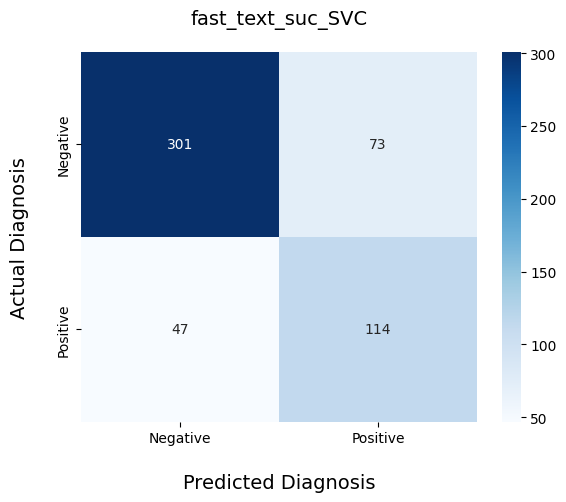

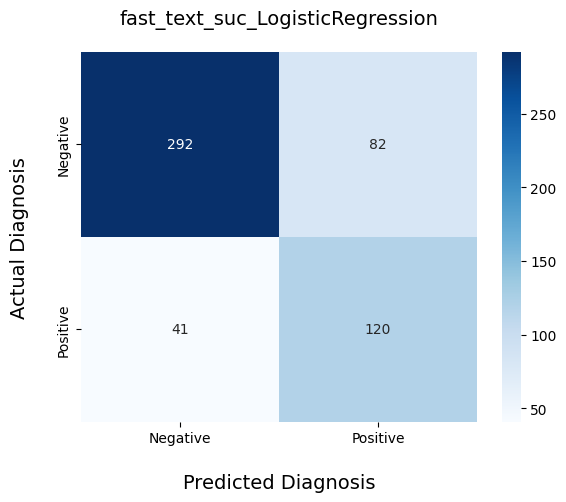

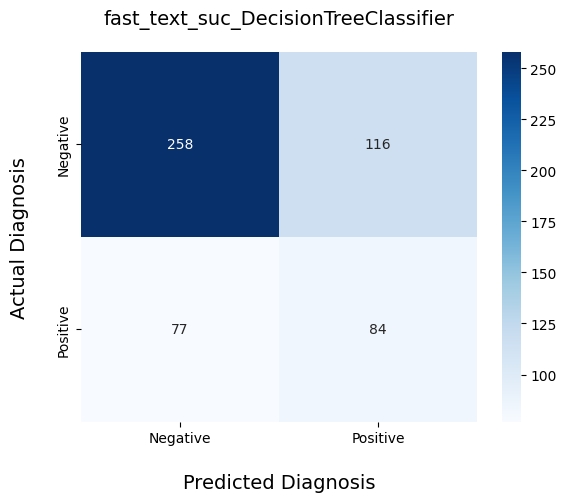

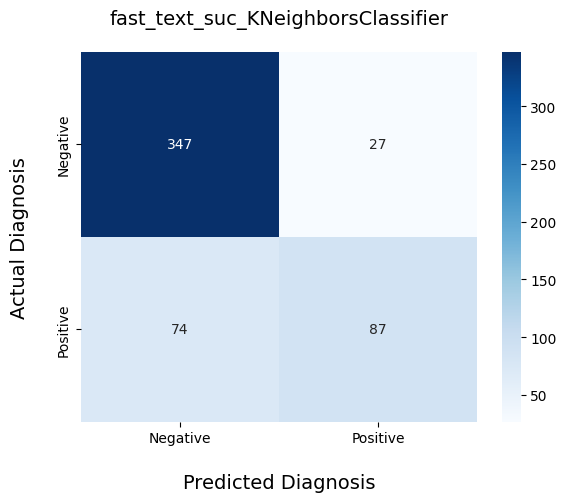

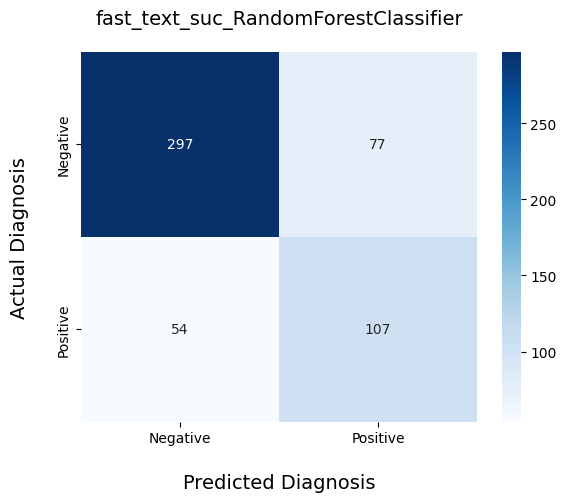

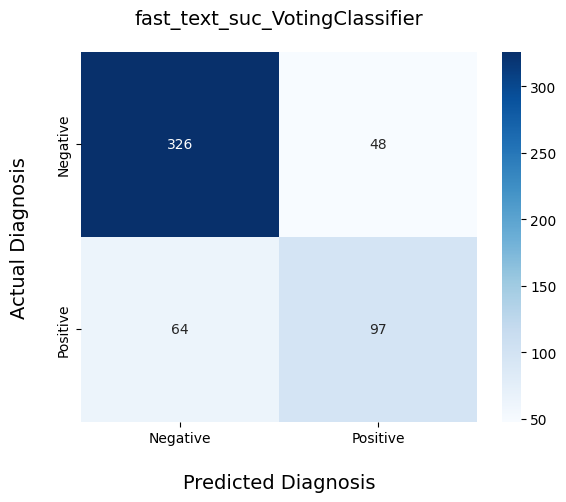

In [190]:
# FastText representations

frames = []

for name, model in task_1_fast_text_suc_models.items():
    y_pred = model["estimator"].predict(X_test_fast_text_suc)

    frames.append(
        {
            "name": name,
            "accuracy": metrics.accuracy_score(y_test_fast_text_suc, y_pred),
            "precision": metrics.precision_score(y_test_fast_text_suc, y_pred),
            "recall": metrics.recall_score(y_test_fast_text_suc, y_pred),
            "f1": metrics.f1_score(y_test_fast_text_suc, y_pred),
            "roc_auc": metrics.roc_auc_score(y_test_fast_text_suc, y_pred),
        }
    )

    ax = sns.heatmap(
        metrics.confusion_matrix(y_test_fast_text_suc, y_pred), annot=True, fmt="d", cmap="Blues"
    )

    ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(["Negative", "Positive"])

    ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(["Negative", "Positive"])

    ax.set_title(name, fontsize=14, pad=20)

    plt.show()

fast_text_suc_metrics_df = pd.DataFrame(frames)

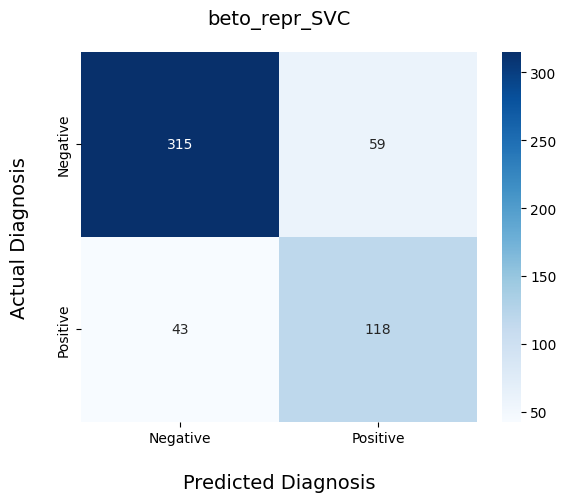

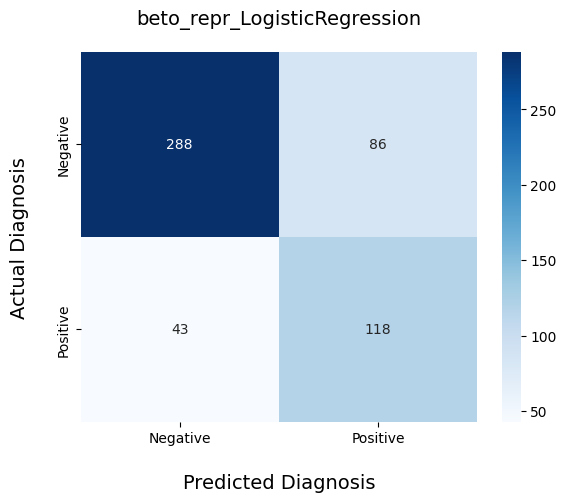

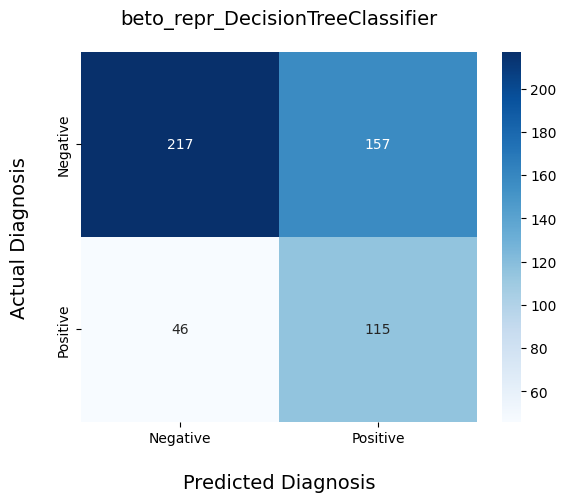

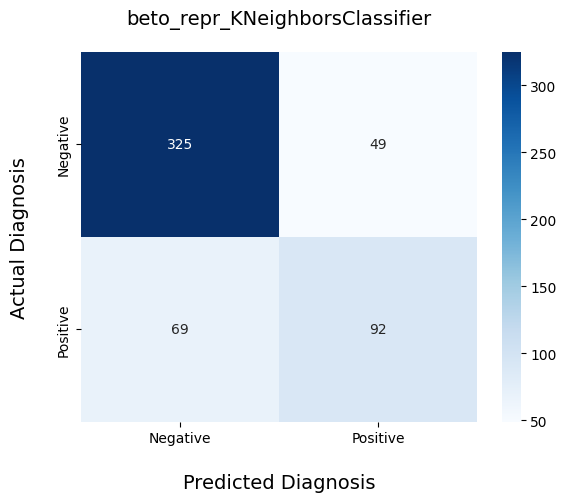

In [191]:
# Beto representations

frames = []

for name, model in task_1_beto_repr_models.items():
    y_pred = model["estimator"].predict(X_test_beto_repr)

    frames.append(
        {
            "name": name,
            "accuracy": metrics.accuracy_score(y_test_beto_repr, y_pred),
            "precision": metrics.precision_score(y_test_beto_repr, y_pred),
            "recall": metrics.recall_score(y_test_beto_repr, y_pred),
            "f1": metrics.f1_score(y_test_beto_repr, y_pred),
            "roc_auc": metrics.roc_auc_score(y_test_beto_repr, y_pred),
        }
    )

    ax = sns.heatmap(
        metrics.confusion_matrix(y_test_beto_repr, y_pred), annot=True, fmt="d", cmap="Blues"
    )

    ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(["Negative", "Positive"])

    ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(["Negative", "Positive"])

    ax.set_title(name, fontsize=14, pad=20)

    plt.show()

beto_repr_metrics_df = pd.DataFrame(frames)

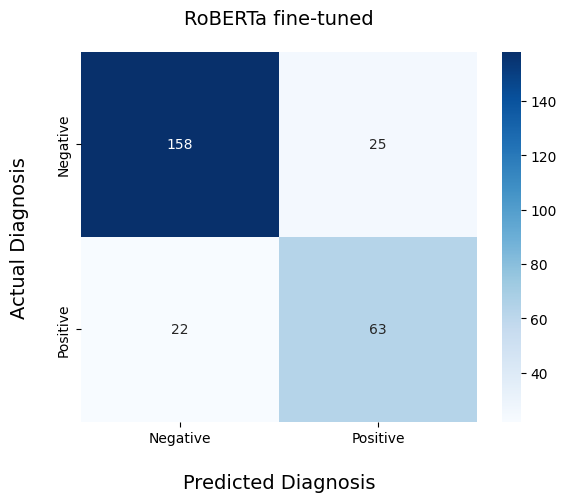

In [202]:
# RoBERTa fine-tuned

preds = []
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device == "cuda":
        roberta_classifier.cuda()

    for test_input, _ in test_data_roberta:
        mask = test_input["attention_mask"].to(device)
        input_ids = test_input["input_ids"].squeeze(1).to(device)

        output = roberta_classifier(input_ids, mask)
        _, output = torch.max(output, dim=1)
        preds.extend(output.cpu().numpy())

ax = sns.heatmap(
    metrics.confusion_matrix(y_test_roberta_ft, preds), annot=True, fmt="d", cmap="Blues"
)

ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(["Negative", "Positive"])

ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(["Negative", "Positive"])

ax.set_title("RoBERTa fine-tuned", fontsize=14, pad=20)

plt.show()

roberta_ft_metrics_df = pd.DataFrame([
    {
        "name": "RoBERTa_fine-tuned",
        "accuracy": metrics.accuracy_score(y_test_roberta_ft, preds),
        "precision": metrics.precision_score(y_test_roberta_ft, preds),
        "recall": metrics.recall_score(y_test_roberta_ft, preds),
        "f1": metrics.f1_score(y_test_roberta_ft, preds),
        "roc_auc": metrics.roc_auc_score(y_test_roberta_ft, preds),
    }
])


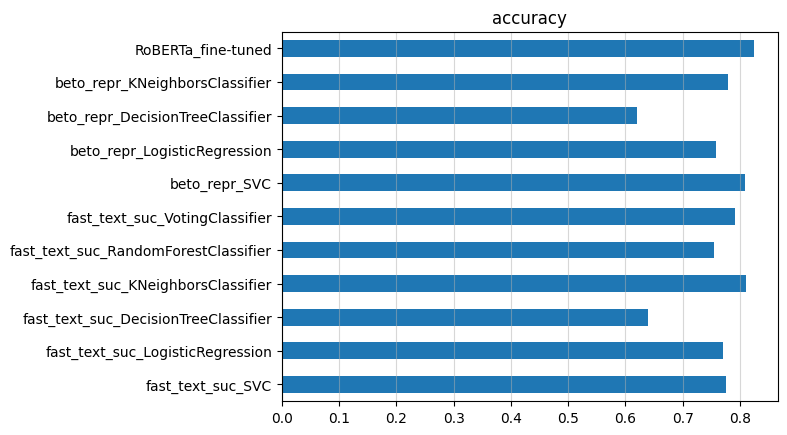

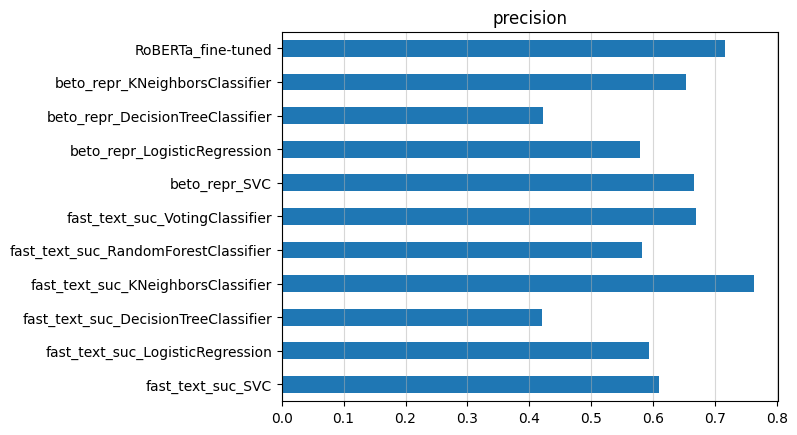

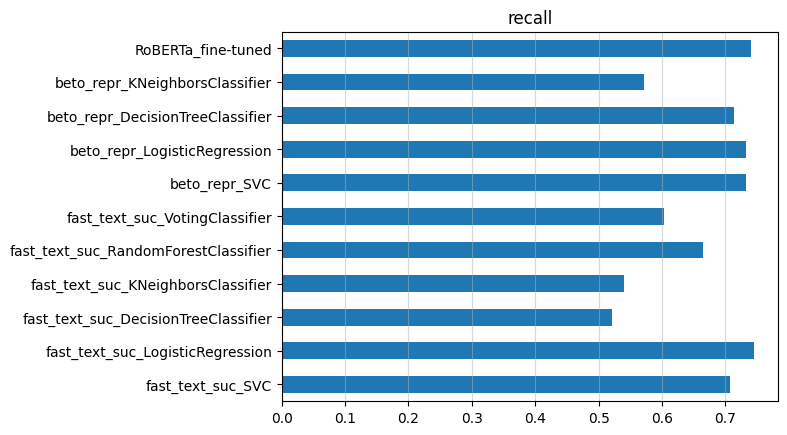

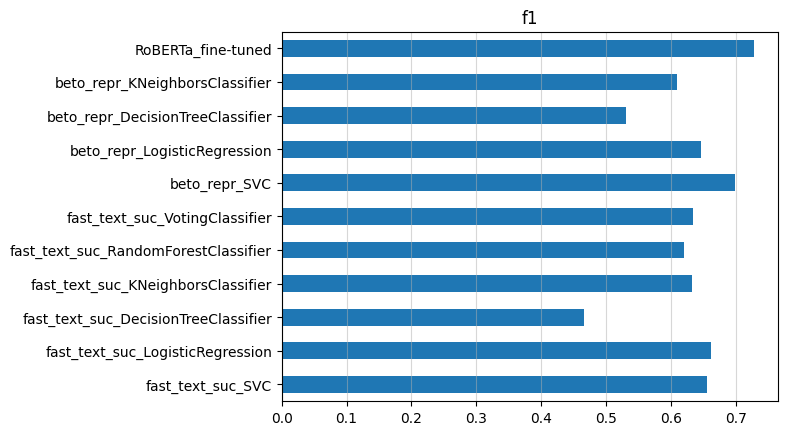

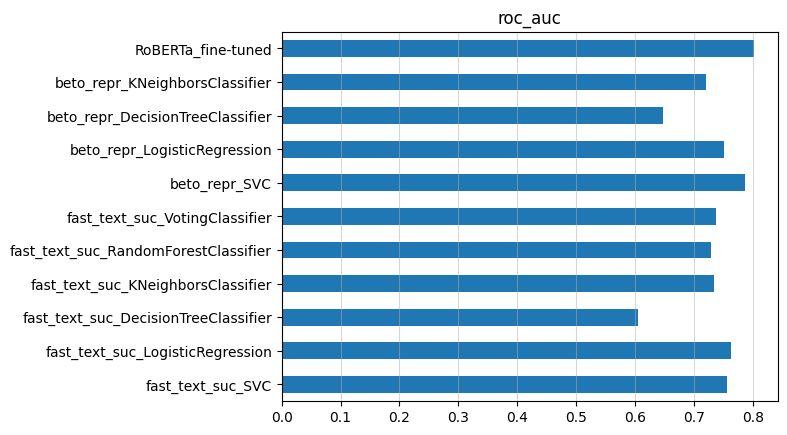

In [203]:
metrics_df = pd.concat([fast_text_suc_metrics_df, beto_repr_metrics_df, roberta_ft_metrics_df])

metrics_df = metrics_df.set_index("name")

for col in metrics_df.columns:
    metrics_df[col].plot(kind="barh")
    plt.title(col)
    plt.grid(axis="x", alpha=0.5)
    plt.ylabel("")
    plt.show()


In [204]:
display(metrics_df)

,accuracy,precision,recall,f1,roc_auc
name,,,,,
fast_text_suc_SVC,0.775701,0.609626,0.708075,0.655172,0.756444
fast_text_suc_LogisticRegression,0.770093,0.594059,0.745342,0.661157,0.763045
fast_text_suc_DecisionTreeClassifier,0.639252,0.420000,0.521739,0.465374,0.605789
fast_text_suc_KNeighborsClassifier,0.811215,0.763158,0.540373,0.632727,0.734090
fast_text_suc_RandomForestClassifier,0.755140,0.581522,0.664596,0.620290,0.729357
fast_text_suc_VotingClassifier,0.790654,0.668966,0.602484,0.633987,0.737071
beto_repr_SVC,0.809346,0.666667,0.732919,0.698225,0.787583
beto_repr_LogisticRegression,0.758879,0.578431,0.732919,0.646575,0.751486
beto_repr_DecisionTreeClassifier,0.620561,0.422794,0.714286,0.531178,0.647250


We can see that the best f1-score was obtained by fine-tuned RoBERTa model. This is not surprising as it is considered as state-of-the-art model for NLP tasks.

We will use the fine-tuned RoBERTa model for the final predictions.

# Subtask 2a: Prejudice Target Detection

In [111]:
CURRENT_TASK = TASK.TWO_A

As the prediction models we have chosen the following:
1. ExtraTreesClassifier
2. RandomForestClassifier

because they are both ensemble methods that are inherently suitable for
multilabel classification.

Main difference between them is that ExtraTreesClassifier is choosing random split among the features resulting in less sensitive to noise in the data and usually faster training time. The downside is that it may require more trees to achieve same performance as RandomForestClassifier.

As a scoring function we will use weighted F1 score, because it is the metric used in the competition.

## FastText embeddings

In [127]:
X, y = get_X_y(fast_text_suc_df, "woman", "lgbtiq", "race", "gordofobia")
X_train_fast_text_suc, X_test_fast_text_suc, y_train_fast_text_suc, y_test_fast_text_suc = train_test_split(
    X, y, test_size=0.2, random_state=RS
)

In [126]:
task_2_fast_text_suc_models = {}

### ExtraTreesClassifier (ensemble method)

For now we will use the default parameters for this model, but we will try to tune them in the future.

In [128]:
NAME = "fast_text_suc_ExtraTreesClassifier"

task_2_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_2_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    # TODO: do GridSearchCV
    param_grid = {}

    task_2_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=ExtraTreesClassifier(random_state=RS, class_weight="balanced"),
            param_grid=param_grid,
            X=X_train_fast_text_suc,
            y=y_train_fast_text_suc,
            scoring = 'f1_weighted',
        )
    }

    save_model(NAME, CURRENT_TASK, task_2_fast_text_suc_models[NAME])

Loaded task_2a/fast_text_suc_ExtraTreesClassifier model from file
Hyperparameters:


{}

Best score: 0.4613 f1_weighted


### RandomForestClassifier (ensemble method)

For now we will use the default parameters for this model, but we will try to tune them in the future.

In [129]:
NAME = "fast_text_suc_RandomForestClassifier"

task_2_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_2_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    # TODO: do GridSearchCV
    param_grid = {}

    task_2_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=RandomForestClassifier(random_state=RS, class_weight="balanced"),
            param_grid=param_grid,
            X=X_train_fast_text_suc,
            y=y_train_fast_text_suc,
            scoring = 'f1_weighted',
        )
    }

    save_model(NAME, CURRENT_TASK, task_2_fast_text_suc_models[NAME])

Loaded task_2a/fast_text_suc_RandomForestClassifier model from file
Hyperparameters:


{}

Best score: 0.4871 f1_weighted


## BETO representation

In [116]:
X, y = get_X_y(beto_repr_df, "woman", "lgbtiq", "race", "gordofobia")
X_train_beto_repr, X_test_beto_repr, y_train_beto_repr, y_test_beto_repr = train_test_split(
    X, y, test_size=0.2, random_state=RS
)

In [117]:
task_2_beto_repr_models = {}

### ExtraTreesClassifier (ensemble method)

In [118]:
NAME = "beto_repr_ExtraTreesClassifier"

task_2_beto_repr_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_2_beto_repr_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    # TODO: do GridSearchCV
    param_grid = {}

    task_2_beto_repr_models[NAME] = {
        **get_best_estimator(
            estimator=ExtraTreesClassifier(random_state=RS, class_weight="balanced"),
            param_grid=param_grid,
            X=X_train_beto_repr,
            y=y_train_beto_repr,
            scoring = 'f1_weighted',
        )
    }

    save_model(NAME, CURRENT_TASK, task_2_beto_repr_models[NAME])

Loaded task_2a/beto_repr_ExtraTreesClassifier model from file
Hyperparameters:


{}

Best score: 0.3594 f1_weighted


### RandomForestClassifier (ensemble method)

In [119]:
NAME = "beto_repr_RandomForestClassifier"

task_2_beto_repr_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_2_beto_repr_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    # TODO: do GridSearchCV

    param_grid = {}

    task_2_beto_repr_models[NAME] = {
        **get_best_estimator(
            estimator=RandomForestClassifier(random_state=RS, class_weight="balanced"),
            param_grid=param_grid,
            X=X_train_beto_repr,
            y=y_train_beto_repr,
            scoring = 'f1_weighted',
        )
    }

    save_model(NAME, CURRENT_TASK, task_2_beto_repr_models[NAME])

Loaded task_2a/beto_repr_RandomForestClassifier model from file
Hyperparameters:


{}

Best score: 0.3797 f1_weighted


## Results

In [130]:
# FastText

frames = []

for name, model in task_2_fast_text_suc_models.items():
    y_pred = model["estimator"].predict(X_test_fast_text_suc)

    frames.append(
        {
            "name": name,
            "accuracy": metrics.accuracy_score(y_test_fast_text_suc, y_pred),
            "f1_weighted": metrics.f1_score(y_test_fast_text_suc, y_pred, average='weighted'),
            "f1_micro": metrics.f1_score(y_test_fast_text_suc, y_pred, average='micro'),
            "f1_macro": metrics.f1_score(y_test_fast_text_suc, y_pred, average='macro'),
        }
    )

fast_text_suc_metrics_df = pd.DataFrame(frames)


In [121]:
# BETO representation

frames = []

for name, model in task_2_beto_repr_models.items():
    y_pred = model["estimator"].predict(X_test_beto_repr)

    frames.append(
        {
            "name": name,
            "accuracy": metrics.accuracy_score(y_test_beto_repr, y_pred),
            "f1_weighted": metrics.f1_score(y_test_beto_repr, y_pred, average='weighted'),
            "f1_micro": metrics.f1_score(y_test_beto_repr, y_pred, average='micro'),
            "f1_macro": metrics.f1_score(y_test_beto_repr, y_pred, average='macro'),
        }
    )

beto_repr_metrics_df = pd.DataFrame(frames)

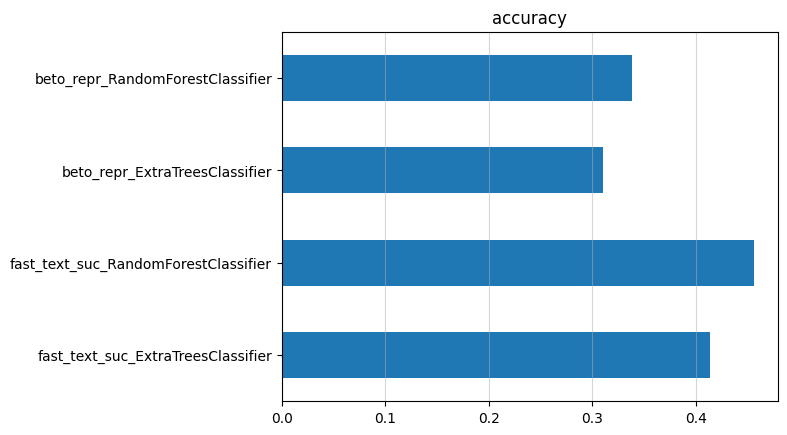

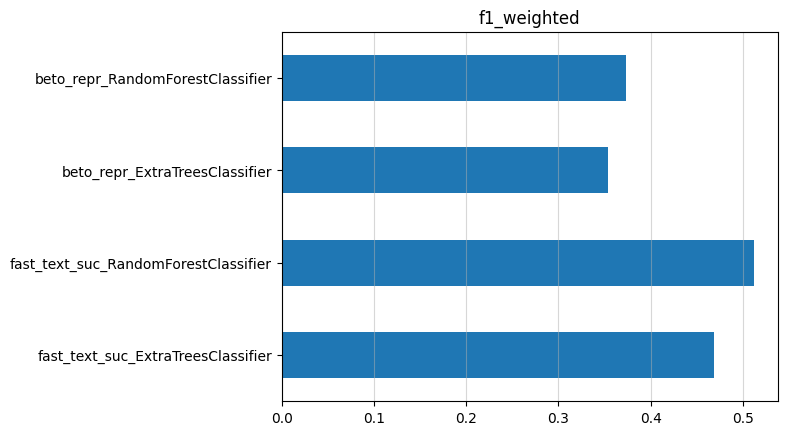

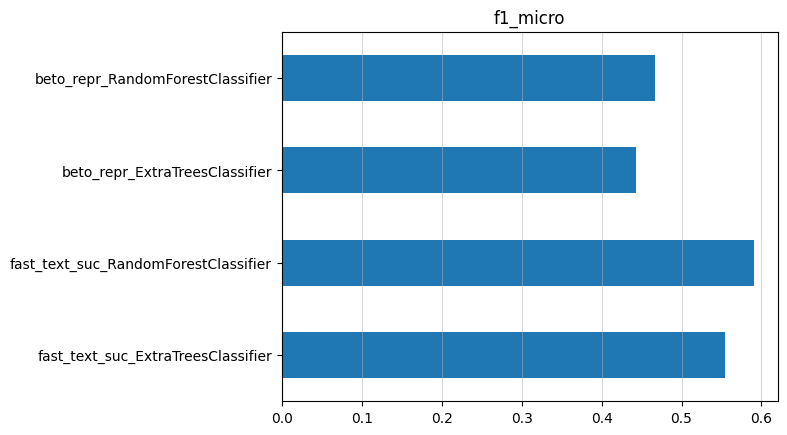

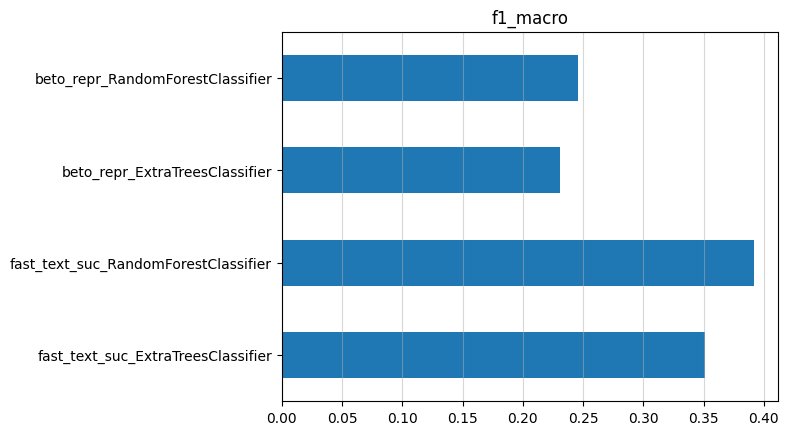

In [131]:
metrics_df = pd.concat([fast_text_suc_metrics_df, beto_repr_metrics_df])

metrics_df = metrics_df.set_index("name")

for col in metrics_df.columns:
    metrics_df[col].plot(kind="barh")
    plt.title(col)
    plt.grid(axis="x", alpha=0.5)
    plt.ylabel("")
    plt.show()

In [132]:
display(metrics_df)

,accuracy,f1_weighted,f1_micro,f1_macro
name,,,,
fast_text_suc_ExtraTreesClassifier,0.413084,0.468601,0.553738,0.350934
fast_text_suc_RandomForestClassifier,0.456075,0.512084,0.590755,0.391941
beto_repr_ExtraTreesClassifier,0.310280,0.354196,0.442478,0.231296
beto_repr_RandomForestClassifier,0.338318,0.373076,0.467405,0.245902


We can see that ExtraTreesClassifier performed worse than RandomForestClassifier. The reason for that may be the mentioned above fact that ExtraTreesClassifier may require more trees to achieve same performance as RandomForestClassifier. When it comes to models trained from BETO representation, the results are worse than the ones obtained from FastText embeddings. We suspect that the reason for that is that we didn't tune any hyperparmeters which resulted in models trained from higher dimensional data to perform worse.

For the HUHU task we will use `fast_text_suc_RandomForestClassifier` model.

# Subtask 2b: Degree of Prejudice Prediction

In [133]:
CURRENT_TASK = TASK.TWO_B

As the prediction models we have chosen the following:

1. SVR
2. ElasticNet
3. SGDRegressor
4. GradientBoostingRegressor


## FastText embeddings

In [134]:
X, y = get_X_y(fast_text_suc_df, "mean")
X_train_fast_text_suc, X_test_fast_text_suc, y_train_fast_text_suc, y_test_fast_text_suc = train_test_split(
    X, y, test_size=0.2, random_state=RS
)

In [135]:
task_2b_fast_text_suc_models = {}

### SVR

SVR is a regression model that uses a kernel to map the data into a higher dimensional space in order to find a linear regression function in that space.

Hyperparameters we decided to tune:
- `C`: Inverse regularization parameter. Described in the SVC section of the notebook.
  - _positive numbers_ `{0.1, 1 (default), 10, 100}`
- `kernel`: Described int the SVC section of the notebook.
  - `linear`
  - `poly`
  - `rbf` (default)
  - `sigmoid`
  

In [140]:
NAME = "fast_text_suc_SVR"

task_2b_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_2b_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
    }

    task_2b_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=SVR(),
            param_grid=param_grid,
            X=X_train_fast_text_suc,
            y=y_train_fast_text_suc,
            scoring="neg_root_mean_squared_error",
        )
    }

    save_model(NAME, CURRENT_TASK, task_2b_fast_text_suc_models[NAME])

Loaded task_2b/fast_text_suc_SVR model from file
Hyperparameters:


{'C': 1, 'degree': 2, 'kernel': 'rbf'}

Best score: -0.7198 neg_root_mean_squared_error


### ElasticNet

ElasticNet is a linear regression model that combines both L1 (Lasso) and L2 (Ridge) regularization penalties. It is particularly useful when dealing with high-dimensional datasets, as it encourages sparsity in the learned coefficients while also handling multicollinearity.

Hyperparameters we decided to tune:
- `alpha`: Controls the strength of regularization. Higher values result in stronger regularization.
    - _positive float_ `{0.0, 0.5, 1.0 (default), 5.0}`
- `max_iter`: Specifies the maximum number of training iterations. Helps control convergence.
    - _positive integers_ `{200, 500, 1000 (default), 2000}`
- `selection`: Determines the method for feature selection during optimization. 
    - `cyclic` (default)
    - `random`
- `l1_ratio` : Balances L1 and L2 regularization penalties. A value of 0 corresponds to Ridge regression, 1 corresponds to Lasso regression.
    - _positive float_ `{0.0, 0.5 (default), 1.0}`
- `random_state` : Sets the random seed for reproducibility.


In [141]:
NAME = "fast_text_suc_ElasticNet"

task_2b_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_2b_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "alpha": [0.0, 0.5, 1.0, 5.0],
        "max_iter": [200, 500, 1000, 2000],
        "selection": ['cyclic', 'random'],
        "l1_ratio" : [0.0, 0.5, 1.0],
    }

    task_2b_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=ElasticNet(random_state=RS),
            param_grid=param_grid,
            X=X_train_fast_text_suc,
            y=y_train_fast_text_suc,
            scoring="neg_root_mean_squared_error",
        )
    }

    save_model(NAME, CURRENT_TASK, task_2b_fast_text_suc_models[NAME])

Loaded task_2b/fast_text_suc_ElasticNet model from file
Hyperparameters:


{'alpha': 0.5,
 'l1_ratio': 0.0,
 'max_iter': 200,
 'random_state': None,
 'selection': 'cyclic'}

Best score: -0.7991 neg_root_mean_squared_error


### SGDRegressor

SGDRegressor stands for Stochastic Gradient Descent Regressor. It is a linear regression model that uses stochastic gradient descent as its optimization algorithm. Unlike traditional linear regression, SGDRegressor performs updates on each training example iteratively, making it suitable for large datasets.

Hyperparameters we decided to tune:
- `loss`: The loss function to be optimized during training. 
  - `squared_error` (default)
  - `epsilon_insensitive` 
  - `huber`
  - `squared_epsilon_insensitive`
- `penalty` : allows apply regularization to the model. Regularization helps to prevent overfitting by adding a penalty term to the loss function. Common regularization options include `l2` (ridge regression, default) and `l1` (Lasso regression). 
- `max_iter`: Specifies the maximum number of training iterations. Helps control convergence.
    - _positive integers_ `{200, 500, 1000 (default), 2000}`
- `learning_rate`: The learning rate controls the contribution of each tree in the ensemble. A lower learning rate means that each tree will have a smaller impact, requiring more trees to be added to the ensemble. A higher learning rate can lead to faster convergence, but it also increases the risk of overfitting.
  - `constant`
  - `optimal`
  - `invscaling` (default)
  - `adaptive`



In [142]:
NAME = "fast_text_suc_SGDRegressor"

task_2b_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_2b_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "loss" : ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive' ],
        "penalty" : ['l2', 'l1', 'elasticnet', None],
        "max_iter": [200, 500, 1000, 2000],
        "learning_rate": ['constant', 'optimal', 'invscaling', 'adaptive'],
    }

    task_2b_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=SGDRegressor(random_state=RS),
            param_grid=param_grid,
            X=X_train_fast_text_suc,
            y=y_train_fast_text_suc,
            scoring="neg_root_mean_squared_error",
        )
    }

    save_model(NAME, CURRENT_TASK, task_2b_fast_text_suc_models[NAME])

Loaded task_2b/fast_text_suc_SGDRegressor model from file
Hyperparameters:


{'learning_rate': 'adaptive',
 'loss': 'squared_error',
 'max_iter': 500,
 'penalty': 'l1'}

Best score: -0.7493 neg_root_mean_squared_error


### GradientBoostingRegressor (ensemble method)

GradientBoostingRegressor is a machine learning model used for regression tasks. It belongs to the boosting family of algorithms, where weak learners (decision trees) are sequentially trained to correct the errors made by the previous models. 

Hyperparameters we decided to tune:
- `learning_rate`: The learning rate controls the contribution of each tree in the ensemble. A lower learning rate means that each tree will have a smaller impact, requiring more trees to be added to the ensemble. A higher learning rate can lead to faster convergence, but it also increases the risk of overfitting.
  - _positive float_ `{0.0, 0.1 (default), 0.3, 0.6}`
- `max_depth`: This parameter determines the maximum depth of each decision tree in the ensemble. A deeper tree can capture more complex interactions in the data but may overfit. It is essential to tune this parameter to find the right trade-off between model complexity and generalization.
  - _positive integer_ `{1, 3 (default), 6}`
- `loss`: The loss function to be optimized during training. 
  - `squared_error` (default)
  - `absolute_error` 
  - `huber`
  - `quantile`
- `criterion` : Specifies the loss function to be used for optimizing the training of decision trees in the ensemble. The loss function quantifies the difference between the predicted values and the actual target values, guiding the learning process to minimize this difference.
  - `friedman_mse` (default)
  - `squared_error`


In [143]:
NAME = "fast_text_suc_GradientBoostingRegressor"

task_2b_fast_text_suc_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_2b_fast_text_suc_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "loss" : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        "learning_rate" : [0.0, 0.1, 0.3, 0.6],
        "criterion": ["friedman_mse", "squared_error"],
        "max_depth": [1, 3, 6],
    }

    task_2b_fast_text_suc_models[NAME] = {
        **get_best_estimator(
            estimator=GradientBoostingRegressor(random_state=RS),
            param_grid=param_grid,
            X=X_train_fast_text_suc,
            y=y_train_fast_text_suc,
            scoring="neg_root_mean_squared_error",
        )
    }

    save_model(NAME, CURRENT_TASK, task_2b_fast_text_suc_models[NAME])

Loaded task_2b/fast_text_suc_GradientBoostingRegressor model from file
Hyperparameters:


{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3}

Best score: -0.7299 neg_root_mean_squared_error


## BETO representation

In [144]:
X, y = get_X_y(beto_repr_df, "mean")
X_train_beto_repr, X_test_beto_repr, y_train_beto_repr, y_test_beto_repr = train_test_split(
    X, y, test_size=0.2, random_state=RS
)

In [145]:
task_2b_beto_repr_models = {}

### SVR

In [146]:
NAME = "beto_repr_SVR"

task_2b_beto_repr_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_2b_beto_repr_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "C": [0.1, 1, 10, 100],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": [2, 3, 4, 5, 6],
    }

    task_2b_beto_repr_models[NAME] = {
        **get_best_estimator(
            estimator=SVR(),
            param_grid=param_grid,
            X=X_train_beto_repr,
            y=y_train_beto_repr,
            scoring="neg_root_mean_squared_error",
        )
    }

    save_model(NAME, CURRENT_TASK, task_2b_beto_repr_models[NAME])

Loaded task_2b/beto_repr_SVR model from file
Hyperparameters:


{'C': 1, 'kernel': 'poly'}

Best score: -0.752 neg_root_mean_squared_error


### ElasticNet

In [147]:
NAME = "beto_repr_ElasticNet"

task_2b_beto_repr_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_2b_beto_repr_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "alpha": [0.0, 0.5, 1.0, 5.0],
        "max_iter": [200, 500, 1000, 2000],
        "selection": ['cyclic', 'random'],
        "l1_ratio" : [0.0, 0.5, 1.0],
    }

    task_2b_beto_repr_models[NAME] = {
        **get_best_estimator(
            estimator=ElasticNet(random_state=RS),
            param_grid=param_grid,
            X=X_train_beto_repr,
            y=y_train_beto_repr,
            scoring="neg_root_mean_squared_error",
        )
    }

    save_model(NAME, CURRENT_TASK, task_2b_beto_repr_models[NAME])

Loaded task_2b/beto_repr_ElasticNet model from file
Hyperparameters:


{'alpha': 1.0, 'l1_ratio': 0.0, 'max_iter': 1000, 'selection': 'cyclic'}

Best score: -0.7565 neg_root_mean_squared_error


### SGDRegressor

In [148]:
NAME = "beto_repr_SGDRegressor"

task_2b_beto_repr_models[NAME] = try_to_load_model(NAME, CURRENT_TASK)

if task_2b_beto_repr_models[NAME] is None:
    print(f"Training {CURRENT_TASK.value}/{NAME} model")

    param_grid = {
        "loss" : ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive' ],
        "penalty" : ['l2', 'l1', 'elasticnet', None],
        "max_iter": [2000],
        "learning_rate": ['constant', 'optimal', 'invscaling', 'adaptive'],
    }

    task_2b_beto_repr_models[NAME] = {
        **get_best_estimator(
            estimator=SGDRegressor(random_state=RS),
            param_grid=param_grid,
            X=X_train_beto_repr,
            y=y_train_beto_repr,
            scoring="neg_root_mean_squared_error",
        )
    }

    save_model(NAME, CURRENT_TASK, task_2b_beto_repr_models[NAME])

Loaded task_2b/beto_repr_SGDRegressor model from file
Hyperparameters:


{'learning_rate': 'invscaling',
 'loss': 'huber',
 'max_iter': 2000,
 'penalty': 'l1'}

Best score: -0.7711 neg_root_mean_squared_error


## Results

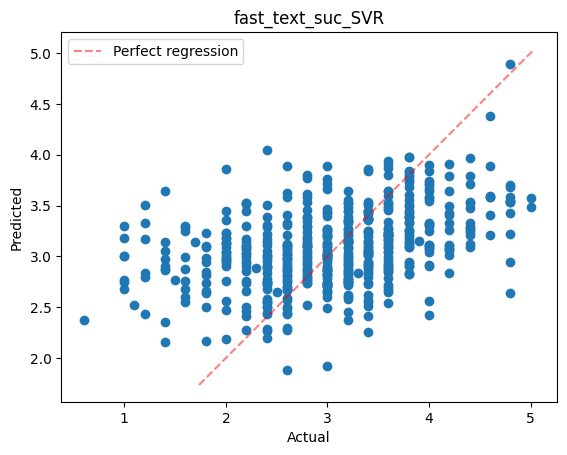

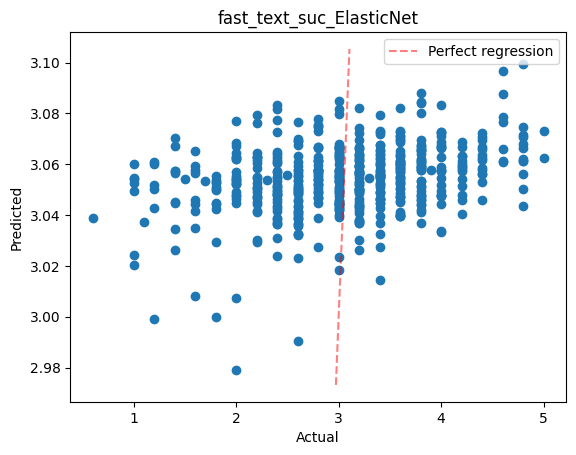

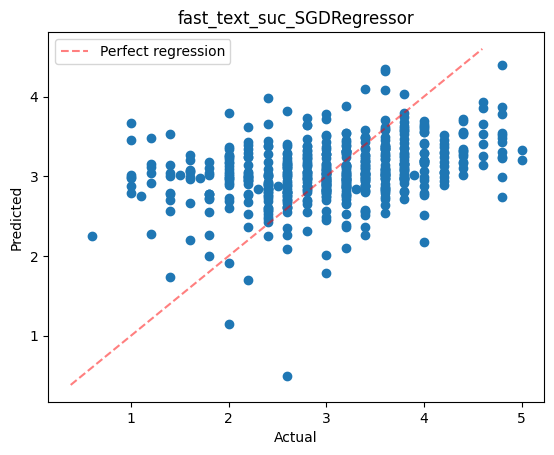

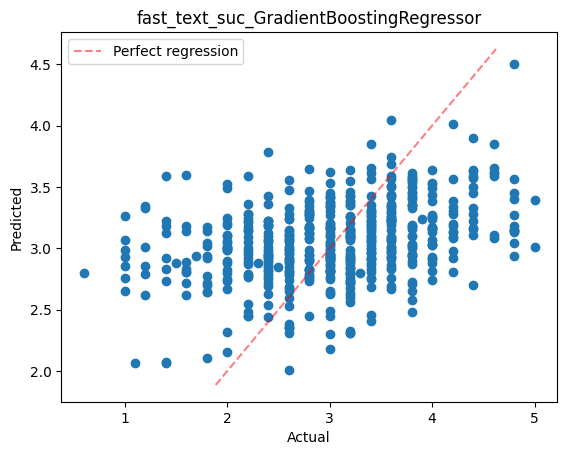

In [149]:
# FastText

frames = []

for name, model in task_2b_fast_text_suc_models.items():
    y_pred = model["estimator"].predict(X_test_fast_text_suc)

    frames.append(
        {
            "name": name,
            "r2": metrics.r2_score(y_test_fast_text_suc, y_pred),
            "rmse": metrics.mean_squared_error(y_test_fast_text_suc, y_pred, squared=False),
        }
    )

    plt.scatter(y_test_fast_text_suc, y_pred)
    plt.title(name)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    min_lim = max(x_min, y_min)
    max_lim = min(x_max, y_max)
    plt.plot([min_lim, max_lim], [min_lim, max_lim], ls="--", alpha=0.5, color="red", label="Perfect regression")
    plt.legend()
    plt.show()

fast_text_suc_metrics_df = pd.DataFrame(frames)

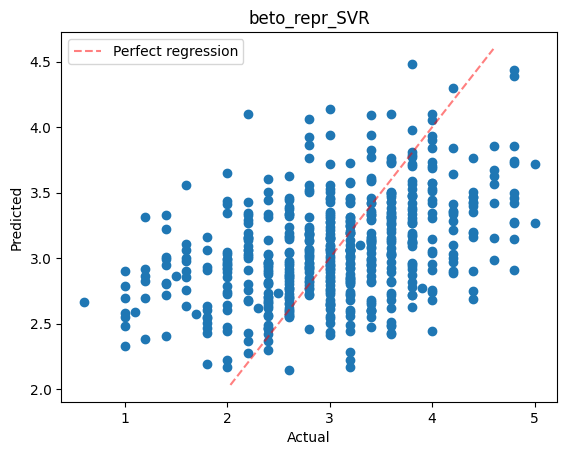

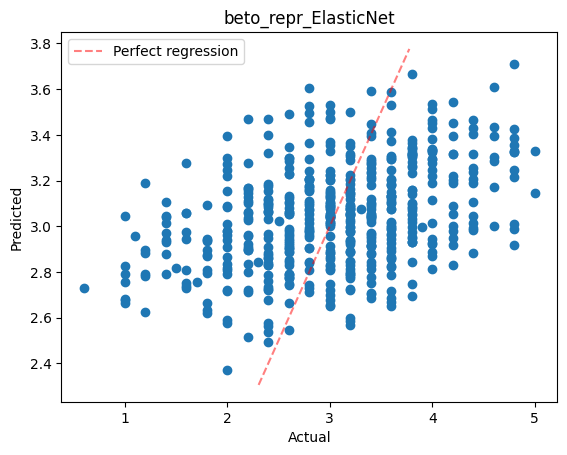

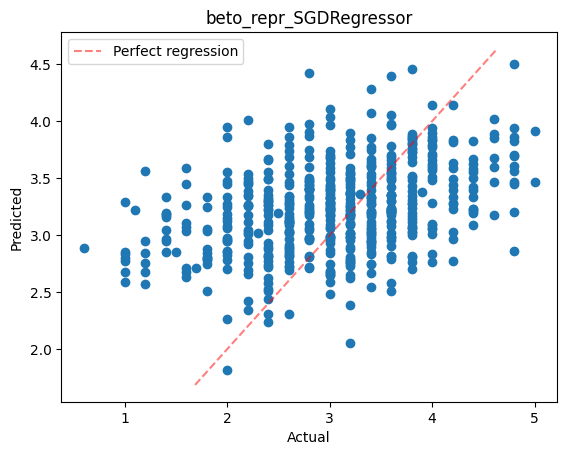

In [150]:
# BETO

frames = []

for name, model in task_2b_beto_repr_models.items():
    y_pred = model["estimator"].predict(X_test_beto_repr)

    frames.append(
        {
            "name": name,
            "r2": metrics.r2_score(y_test_beto_repr, y_pred),
            "rmse": metrics.mean_squared_error(y_test_beto_repr, y_pred, squared=False),
        }
    )

    plt.scatter(y_test_beto_repr, y_pred)
    plt.title(name)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    min_lim = max(x_min, y_min)
    max_lim = min(x_max, y_max)
    plt.plot([min_lim, max_lim], [min_lim, max_lim], ls="--", alpha=0.5, color="red", label="Perfect regression")
    plt.legend()
    plt.show()

beto_repr_metrics_df = pd.DataFrame(frames)

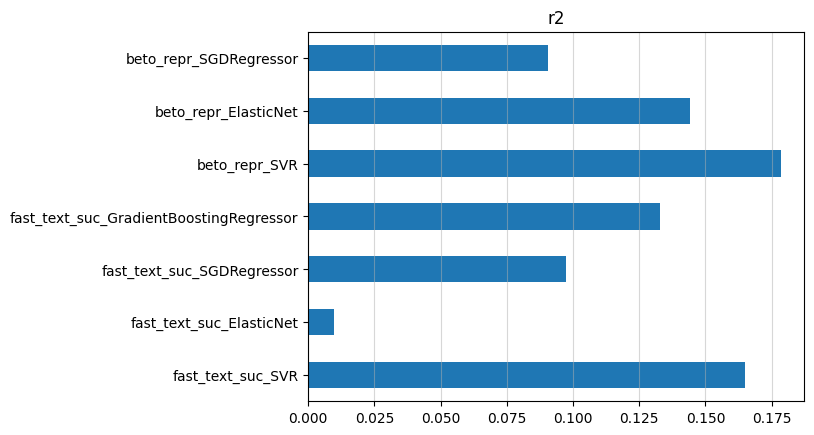

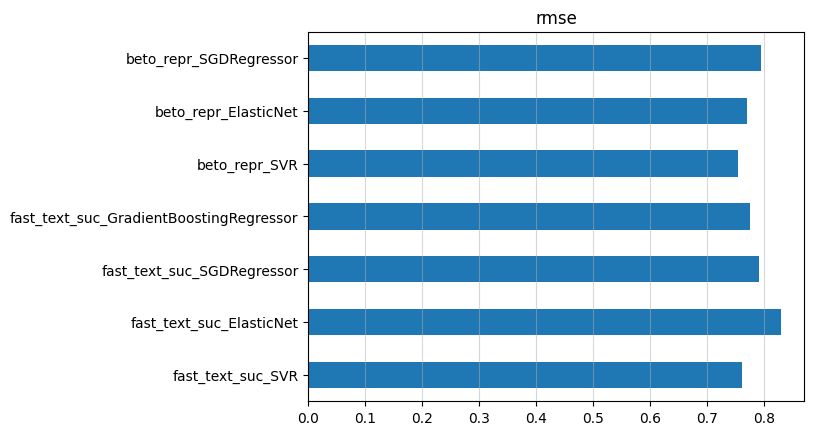

In [151]:
metrics_df = pd.concat([fast_text_suc_metrics_df, beto_repr_metrics_df])

metrics_df = metrics_df.set_index("name")

for col in metrics_df.columns:
    metrics_df[col].plot(kind="barh")
    plt.title(col)
    plt.grid(axis="x", alpha=0.5)
    plt.ylabel("")
    plt.show()

In [152]:
display(metrics_df)

,r2,rmse
name,,
fast_text_suc_SVR,0.164753,0.760900
fast_text_suc_ElasticNet,0.009656,0.828539
fast_text_suc_SGDRegressor,0.097335,0.791013
fast_text_suc_GradientBoostingRegressor,0.132704,0.775361
beto_repr_SVR,0.178368,0.754673
beto_repr_ElasticNet,0.144262,0.770177
beto_repr_SGDRegressor,0.090629,0.793945


We can see that on the test set the best performing model was `beto_repr_SVR`. It outperformed the best performing (on the K-Fold validation) model `fast_text_suc_SVR`. It indicates that the BETO representation is more capable of capturing the degree of prejudice in the text than FastText embeddings without overfitting. Nevertheless, the performance of the models is still far from satisfactory. For the HUHU task we will use `beto_repr_SVR` model.

# HUHU deliverable

Seeing that in the first task fine-tuned RoBERTa outperformed all other models suggest that it would only make sense to try this approach for other tasks. Unfortunately we didn't have enough time to do that. We also didn't find time to train the RoBERTa model on the whole dataset, so we will use the model trained during the evaluation.

In [154]:
TASK_2A_MODEL_NAME = "fast_text_suc_RandomForestClassifier"
TASK_2B_MODEL_NAME = "beto_repr_SVR"

In [159]:
# Train the best model on the whole training set
task_2a_model_params = try_to_load_model(TASK_2A_MODEL_NAME, TASK.TWO_A)["params"]

X, y = get_X_y(fast_text_suc_df, "woman", "lgbtiq", "race", "gordofobia")
task_2a_model = RandomForestClassifier(**task_2a_model_params, class_weight="balanced", random_state=RS)
task_2a_model.fit(X, y)

Loaded task_2a/fast_text_suc_RandomForestClassifier model from file
Hyperparameters:


{}

Best score: 0.4871 f1_weighted


RandomForestClassifier(class_weight='balanced', random_state=42)

In [161]:
# Train the best model on the whole training set
task_2b_model_params = try_to_load_model(TASK_2B_MODEL_NAME, TASK.TWO_B)["params"]

X, y = get_X_y(beto_repr_df, "mean")
task_2b_model = SVR(**task_2b_model_params)
task_2b_model.fit(X, y)

Loaded task_2b/beto_repr_SVR model from file
Hyperparameters:


{'C': 1, 'kernel': 'poly'}

Best score: -0.752 neg_root_mean_squared_error


SVR(C=1, kernel='poly')

In [153]:
test_data = pd.read_csv(TEST_PATH)
display(test_data.head())

,index,tweet
0,52830,-Mamá en la escuela me dicen gorda -Pobresilla...
1,78883,"No te sientas diferente, da igual si eres negr..."
2,78926,Si esta asi.. SUPER SI.. y que se pongan celos...
3,61844,—Bebé ¿Me veo gorda con este vestido?\n—¡No mi...
4,78830,Las mujeres solo desean 2 cosas en la vida: co...


In [206]:
# Create the same RoBERTa representation for the test data
test_data_for_roberta = DatasetBinary(roberta_tokenizer, test_data["tweet"], None, mode="test")

In [166]:
# Create the same FastText representation as in the training set
test_data["fast_text_suc"] = list(nlp.pipe(test_data["tweet"]))
test_data["fast_text_suc"] = test_data["fast_text_suc"].apply(lambda x: [token for token in x])
test_data["fast_text_suc"] = filter_tokens(
    test_data["fast_text_suc"], [Filter.SPACE, Filter.TAGS, Filter.NEWLINE]
)
test_data["fast_text_suc"] = test_data["fast_text_suc"].apply(
    lambda tokens: [token.text for token in tokens]
)
test_data["fast_text_suc"] = test_data["fast_text_suc"].apply(
    lambda tokens: get_sentence_embedding(tokens, fast_text_suc_model)
)

display(test_data.head())

,index,tweet,fast_text_suc
0,52830,-Mamá en la escuela me dicen gorda -Pobresilla...,"[-0.15210082, -0.33220673, -0.040581636, -0.12..."
1,78883,"No te sientas diferente, da igual si eres negr...","[-0.083679065, -0.32409346, 0.12849523, -0.134..."
2,78926,Si esta asi.. SUPER SI.. y que se pongan celos...,"[-0.144652, -0.26838, -0.10397144, -0.1310671,..."
3,61844,—Bebé ¿Me veo gorda con este vestido?\n—¡No mi...,"[-0.21017079, -0.362469, 0.049311157, -0.11924..."
4,78830,Las mujeres solo desean 2 cosas en la vida: co...,"[-0.05191478, -0.22388896, 0.019090569, -0.116..."


In [167]:
# Create the same BETO representation as in the training set
beto_input = beto_tokenizer(
    test_data["tweet"].tolist(),
    padding=True,
    truncation=True,
    max_length=35,
    return_tensors="pt"
)

beto_model.eval()

if torch.cuda.is_available():
    beto_input = beto_input.to("cuda")
    beto_model.to("cuda")
else:
    print("CUDA is not available")

with torch.no_grad():
    beto_output = beto_model(**beto_input)
    test_data["beto_repr"] = beto_output[0][:, 0, :].cpu().numpy().tolist()

display(test_data.head())

CUDA is not available


,index,tweet,fast_text_suc,beto_repr
0,52830,-Mamá en la escuela me dicen gorda -Pobresilla...,"[-0.15210082, -0.33220673, -0.040581636, -0.12...","[-0.03423670679330826, -0.1813754439353943, -0..."
1,78883,"No te sientas diferente, da igual si eres negr...","[-0.083679065, -0.32409346, 0.12849523, -0.134...","[-0.40077710151672363, 0.03688787668943405, 0...."
2,78926,Si esta asi.. SUPER SI.. y que se pongan celos...,"[-0.144652, -0.26838, -0.10397144, -0.1310671,...","[-0.22770968079566956, -0.013093028217554092, ..."
3,61844,—Bebé ¿Me veo gorda con este vestido?\n—¡No mi...,"[-0.21017079, -0.362469, 0.049311157, -0.11924...","[0.28202638030052185, -0.21486109495162964, 0...."
4,78830,Las mujeres solo desean 2 cosas en la vida: co...,"[-0.05191478, -0.22388896, 0.019090569, -0.116...","[0.6721341013908386, 1.603137493133545, 0.8566..."


In [207]:
results = pd.DataFrame()
results["tweet_id"] = test_data["index"]

# Concat to results predictions from task 1
preds = []
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device == "cuda":
        roberta_classifier.cuda()

    for test_input, _ in test_data_for_roberta:
        mask = test_input["attention_mask"].to(device)
        input_ids = test_input["input_ids"].squeeze(1).to(device)

        output = roberta_classifier(input_ids, mask)
        _, output = torch.max(output, dim=1)
        preds.extend(output.cpu().numpy())

results["humor"] = preds

# Concat to results predictions columns from task 2a
results_2a = task_2a_model.predict(test_data["fast_text_suc"].apply(pd.Series))
results_2a = pd.DataFrame(results_2a, columns=["prejudice_group1", "prejudice_group2", "prejudice_group3", "prejudice_group4"])
results = pd.concat([results, results_2a], axis=1)

# Concat to results predictions from task 2b
results["prejudice_degree"] = task_2b_model.predict(test_data["beto_repr"].apply(pd.Series))


display(results.head())
results.to_csv(os.path.join(os.getcwd(), "Saradam_1.csv"), index=False)

,tweet_id,humor,prejudice_group1,prejudice_group2,prejudice_group3,prejudice_group4,prejudice_degree
0,52830,1,1,0,0,1,3.022002
1,78883,1,0,0,1,0,3.432494
2,78926,0,1,0,0,0,2.804241
3,61844,1,1,0,0,1,2.610481
4,78830,1,1,0,0,0,3.332310
